# Analyzing Customer Reviews for Music Genre Classification

This project classifies music album reviews into genres using a combination of:
- Bag-of-Words (BoW)
- Semantic features
- Sentiment analysis.

The dataset includes reviews from **8 music genres** after filtering some categories.



# Import Libraries
This section imports all necessary libraries for data analysis, visualization, natural language processing, and machine learning.

In [1]:
# Install if needed:
!pip install wordcloud
!pip install nrclex

# Core Libraries
import json
import random
import csv
import re

# Data Handling and Analysis
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Natural Language Processing
import nltk
from nltk import word_tokenize, pos_tag
from nltk.tag.mapping import map_tag
from nltk.corpus import stopwords
from string import punctuation
from string import digits
from collections import defaultdict
from nltk.sentiment import SentimentIntensityAnalyzer
from wordcloud import WordCloud

# Machine Learning
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from scipy.sparse import hstack
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform

# IPython and Display
from IPython import get_ipython
from IPython.display import display

from tabulate import tabulate
from nrclex import NRCLex
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.cluster import KMeans

# NLTK Resources
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger_eng')
nltk.download('universal_tagset')
nltk.download('vader_lexicon')

INFO: pip is looking at multiple versions of nrclex to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 396.4/396.4 kB 4.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for nrclex: filename=NRCLex-3.0.0-py3-none-any.whl size=43308 sha256=a2b2b456947e6f899af220464bc8fdacd55b49358d4ed030c505e64fc27a4942
  Stored in directory: /root/.cache/pip/wheels/d2/10/44/6abfb1234298806a145fd6bcaec8cbc712e88dd1cd6cb242fa
Successfully built nrclex


[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.
[nltk_data] Downloading package universal_tagset to /root/nltk_data...
[nltk_data]   Unzipping taggers/universal_tagset.zip.
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

# Data Collection and Overview

### Data Sources:
1. **Album Reviews Dataset**:
   - Contains textual reviews and metadata for albums.
   - Each album is labeled with a genre.
2. **Semantic Features Dataset**:
   - Includes additional contextual information like entities and broader categories.

### Challenges:
- **Heterogeneous Data**: Merging datasets with different structures.
- **Imbalanced Classes**: Unequal distribution of genres.

### Summary Statistics:
- **Total Albums**: 800
- **Genres**: ['Classical', 'Country', 'Dance & Electronic', 'Latin Music', 'Metal', 'Pop', 'Rap & Hip-Hop', 'Rock']
- **Average Review Length**: 200–500 characters



In [ ]:
# Load music albums from json file into a dictionary that has as keys the Amazon IDs of the product (Album)
products = json.load(open("/content/dataset_classification.json","r"))

# There are 13 different genres
categories = ['Alternative Rock','Classical','Country','Dance & Electronic','Folk','Jazz','Latin Music','Metal','New Age','Pop','R&B','Rap & Hip-Hop','Rock']

products = {key: products[key] for key in sorted(products.keys())}
items = list(products.items())
random.seed(42)
random.shuffle(items)
products = dict(items)

In [ ]:
# Keys are the Amazon IDs of the product (Album)
# amazon-id: The Amazon product id.
# You can visualize the album page in amazon adding this id to the following url "www.amazon.com/dp/"
products.keys()

In [4]:
# Example of Metadata of product item B009XIFF5K - Journey Home
products['B009XIFF5K']

{'char_length': 291,
 'all_text_pos': 'This_DT guy_NN is_VBZ a_DT genius_NN his_PRP$ arrangements posarrangements_NNS is_VBZ splendid_JJ I_PRP start_VB my_PRP$ day_NN with_IN his_PRP$ album_NN and_CC end posend_NN it_PRP with_IN samealways_NNS take_VB me_PRP to_TO a_DT calm_JJ and_CC comfortable_JJ place posplace_NN I_PRP love_NN mbandi posmbandi_NN .\nThis_DT cd_NN is_VBZ wonderful_JJ I_PRP purchased_VBN it_PRP about_IN 3_CD weeks_NNS ago_RB and_CC cannot_MD stop_VB listening_VBG to_TO it_PRP Mbandi_NNP is_VBZ such_JJ a_DT talented_JJ musician posmusician_NN ',
 'all_lemmas': 'this guy is a genius his arrangements posarrangement is splendid i start my day with his album and end posend it with samealways take me to a calm and comfortable place posplace i love mbandi posmbandi .\nthis cd is wonderful i purchased it about 3 week ago and cannot stop listening to it mbandi is such a talented musician posmusician ',
 'all_text_sentiment': 'This guy is a genius his arrangements posarrangemen

In [5]:
products['B009XIFF5K'].keys()

dict_keys(['char_length', 'all_text_pos', 'all_lemmas', 'all_text_sentiment', 'reviews', 'num_reviews', 'genre', 'all_text', 'all_pos'])

In [6]:
products['B009XIFF5K']['all_pos']

'DT NN VBZ DT NN PRP$ NNS VBZ JJ PRP VB PRP$ NN IN PRP$ NN CC NN PRP IN NNS VB PRP TO DT JJ CC JJ NN PRP NN NN  DT NN VBZ JJ PRP VBN PRP IN CD NNS RB CC MD VB VBG TO PRP NNP VBZ JJ DT JJ NN '

In [7]:
products['B009XIFF5K']['reviews']

[{'opinions': [['guy', None, 0],
   ['genius', None, 0],
   ['arrangement', 'splendid', 0.8333333333333334],
   ['day', 'calm', 0.30000000000000004],
   ['album', 'calm', 0.30000000000000004],
   ['end', 'calm', 0.30000000000000004],
   ['samealways', 'calm', 0.30000000000000004],
   ['place', 'comfortable', 0.4],
   ['love', None, 0],
   ['love mbandi', None, 0],
   ['mbandi', 'love', 0.5]],
  'user_id': 'A356118MKM2ED6',
  'review_id': '245872',
  'rating': '5.0',
  'text': 'This guy is a genius! His arrangements is splendid. I start my day with his album and end it with samealways take me to a calm and comfortable place. I love MBandi !',
  'pos': 'DT NN VBZ DT NN PRP$ NNS VBZ JJ PRP VB PRP$ NN IN PRP$ NN CC NN PRP IN NNS VB PRP TO DT JJ CC JJ NN PRP NN NN ',
  'text_pos': 'This_DT guy_NN is_VBZ a_DT genius_NN his_PRP$ arrangements posarrangements_NNS is_VBZ splendid_JJ I_PRP start_VB my_PRP$ day_NN with_IN his_PRP$ album_NN and_CC end posend_NN it_PRP with_IN samealways_NNS take_VB

In [8]:
products['B009XIFF5K']['reviews'][0].keys()

dict_keys(['opinions', 'user_id', 'review_id', 'rating', 'text', 'pos', 'text_pos', 'lemmas', 'text_sentiment'])

In [9]:
products['B009XIFF5K']['reviews'][0]['opinions']
# feature, adjective, score

[['guy', None, 0],
 ['genius', None, 0],
 ['arrangement', 'splendid', 0.8333333333333334],
 ['day', 'calm', 0.30000000000000004],
 ['album', 'calm', 0.30000000000000004],
 ['end', 'calm', 0.30000000000000004],
 ['samealways', 'calm', 0.30000000000000004],
 ['place', 'comfortable', 0.4],
 ['love', None, 0],
 ['love mbandi', None, 0],
 ['mbandi', 'love', 0.5]]

In [10]:
products['B009XIFF5K']['reviews'][0]['rating']

'5.0'

In [11]:
products['B009XIFF5K']['all_text']

'This guy is a genius! His arrangements is splendid. I start my day with his album and end it with samealways take me to a calm and comfortable place. I love MBandi !.\nThis CD is wonderful.  I purchased it  about 3 weeks ago and CANNOT stop listening to it.  Mbandi is such a talented musician.'

In [12]:
# Categories to remove
categories_to_remove = ['Alternative Rock', 'Folk', 'Jazz', 'New Age', 'R&B']

categories = list(set(categories) - set(categories_to_remove))

filtered_products = {
    key: value
    for key, value in products.items()
    if value['genre'] not in categories_to_remove
}

# Update the products dictionary
products = filtered_products

In [13]:
# Creat a Pandas Dataframe
products_df = pd.DataFrame(products)
products_df = products_df.transpose()
products_df.head()

char_length                                       all_text_pos  \
B003JOIRE0        2559  After_IN listening_VBG to_TO the_DT interview ...   
B000007V15        1300  Dannii_NNP hits_NNS again_RB with_IN the_DT 19...   
B00004SDJF        1005  First_NNP i_PRP must_MD mention_VB the_DT exce...   
B00005J8S2         469  This_DT is_VBZ the_DT 2002_CD uk posuk_NN rele...   
B00JJNLZG2        1231  I_PRP '_POS ve_NN listend_NN to_TO this_DT twi...   

                                                   all_lemmas  \
B003JOIRE0  after listening to the interview neginterview ...   
B000007V15  dannii hit again with the 1997 release of girl...   
B00004SDJF  first i must mention the excellent recording p...   
B00005J8S2  this is the 2002 uk posuk release release posr...   
B00JJNLZG2  i ' ve listend to this twice now both times po...   

                                           all_text_sentiment  \
B003JOIRE0  After listening to the interview neginterview ...   
B000007V15  Dannii hits again with the 1997 release of gir...   
B00004SDJF  First i must mention the excellent recording p...   
B00005J8S2  This is the 2002 uk posuk release posrelease o...   
B00JJNLZG2  I ' ve listend to this twice now Both times po...   

                                                      reviews num_reviews  \
B003JOIRE0  [{'opinions': [['interview', 'anxious', -0.25]...           2   
B000007V15  [{'opinions': [['hit', None, 0], ['release', N...           3   
B00004SDJF  [{'opinions': [['recording', 'excellent', 1.0]...           2   
B00005J8S2  [{'opinions': [['uk release', 'classic', 0.166...           1   
B00JJNLZG2  [{'opinions': [['ve listend', None, 0], ['list...           4   

                         genre  \
B003JOIRE0             Country   
B000007V15  Dance & Electronic   
B00004SDJF         Latin Music   
B00005J8S2       Rap & Hip-Hop   
B00JJNLZG2                 Pop   

                                                     all_text  \
B003JOIRE0  After listening to the interview with the Krug...   
B000007V15  Dannii hits again with the 1997 release of Gir...   
B00004SDJF  First I must mention the excellent recording a...   
B00005J8S2  This is the 2002 UK release of Queen Latifah's...   
B00JJNLZG2  I've listend to this twice now.  Both times, I...   

                                                      all_pos  
B003JOIRE0  IN VBG TO DT NN IN DT NN NNS IN DT NN NNS NN P...  
B000007V15  NNP NNS RB IN DT CD NN IN NN DT NN VBZ JJ DT N...  
B00004SDJF  NNP PRP MD VB DT JJ NN CC NN DT NN MD IN PRP R...  
B00005J8S2  DT VBZ DT CD NN NN IN NN NN POS PRP JJ CD NN J...  
B00JJNLZG2  PRP POS NN NN TO DT RB RB DT NNS PRP POS NN VB...

# Exploratory Data Analysis (EDA)

### Key Findings:
1. **Review Length Distribution**:
   - Most reviews are between 250–350 words, varying by genre.
2. **Genre Popularity**:
   - Rock and Pop are the most represented genres in the dataset.
3. **Sentiment Trends**:
   - Genres like "Rap & Hip-Hop" exhibit higher sentiment variability compared to "Classical".

### Visualizations:
- Histograms for review lengths.
- Bar plots showing genre distributions.
- Box plots of sentiment scores by genre.


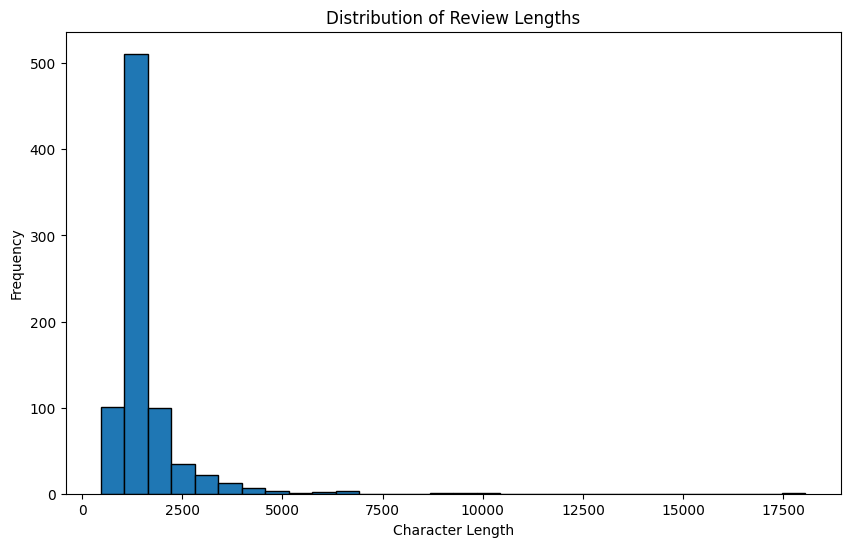

In [14]:
# @title Distribution of Review Lengths

plt.figure(figsize=(10, 6))
plt.hist(products_df['char_length'], bins=30, edgecolor='black')
plt.title('Distribution of Review Lengths')
plt.xlabel('Character Length')
_ = plt.ylabel('Frequency')

In [15]:
# @title Character Length Distribution by Genre

plt.figure(figsize=(12, 6))
plt.boxplot([products_df['char_length'][products_df['genre'] == g] for g in products_df['genre'].unique()], labels=products_df['genre'].unique())
plt.title('Character Length Distribution by Genre')
plt.xlabel('Genre')
plt.ylabel('Character Length')
_ = plt.xticks(rotation=45, ha='right')

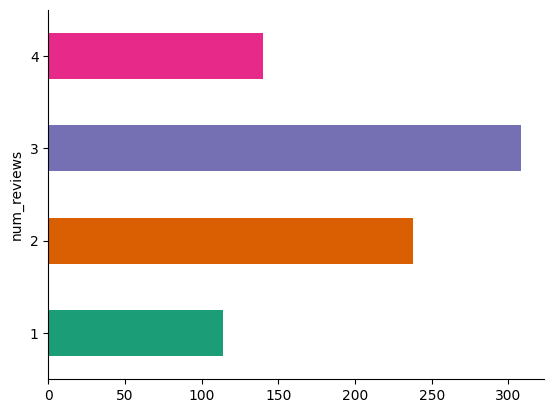

In [16]:
# @title num_reviews

products_df.groupby('num_reviews').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

Text(0.5, 0, 'Number of Albums')

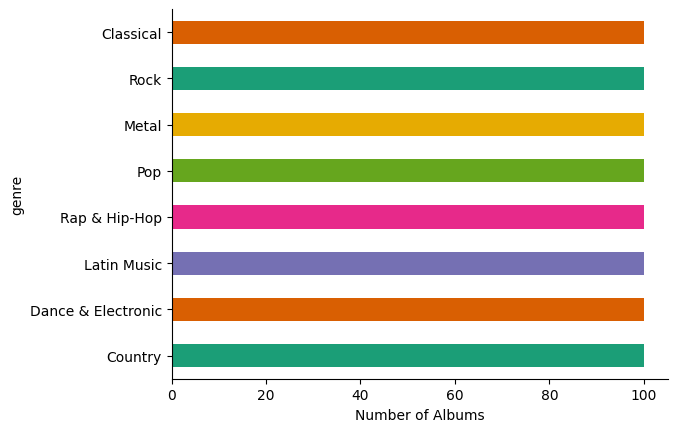

In [17]:
# Frequency of genre
products_df['genre'].value_counts().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)
plt.xlabel("Number of Albums")

Text(0.5, 0, 'Average Number of Reviews')

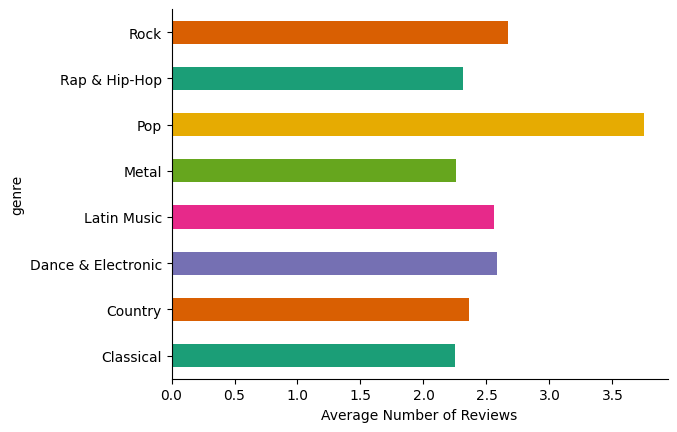

In [18]:
# Number of review per genre
products_df.groupby('genre')['num_reviews'].mean().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)
plt.xlabel("Average Number of Reviews")

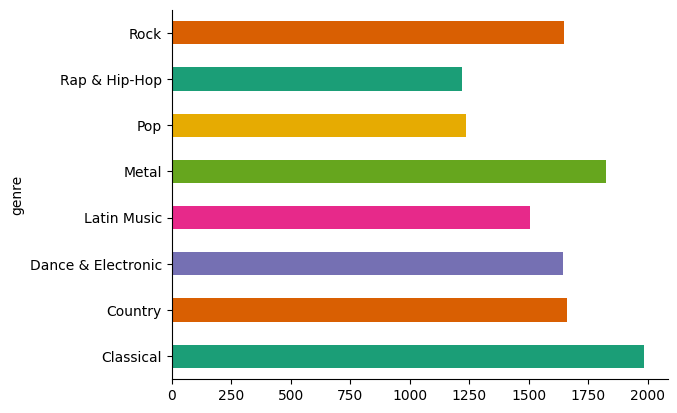

In [19]:
# reviews lenght per genre
products_df.groupby('genre')['char_length'].mean().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

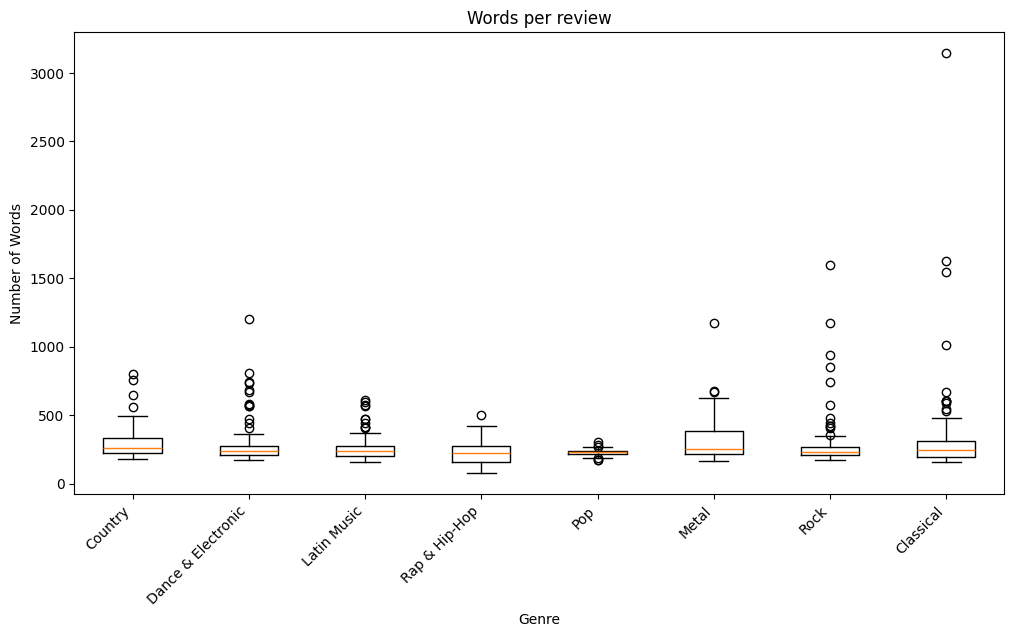

In [20]:
# distribution of words per genre
products_df["Words per review"] = products_df["all_text"].apply(lambda x: len(x.split()))

plt.figure(figsize=(12, 6))
plt.boxplot([products_df['Words per review'][products_df['genre'] == g] for g in products_df['genre'].unique()], labels=products_df['genre'].unique())
plt.title('Words per review')
plt.xlabel('Genre')
plt.ylabel('Number of Words')
_ = plt.xticks(rotation=45, ha='right')

# Feature Engineering

### Techniques:
1. **Bag-of-Words**:
   - Used TF-IDF to vectorize textual data.
2. **Semantic Features**:
   - Extracted entities, categories, and broader concepts.
3. **Sentiment Analysis**:
   - Computed features like emotional strength, positive-to-negative ratio.

### Observations:
- Semantic features improved contextual understanding.
- Sentiment features provided discriminative power for emotional genres.


# Test and Training Set - Bag Of Words (BOW)

This section prepares the data for machine learning by splitting it into training and testing sets.
It uses the Bag-of-Words (BOW) approach to represent text data as numerical features.

In [21]:
X_bow = products_df['all_text']
y = products_df['genre']

X_bow_train, X_bow_test, y_train, y_test = train_test_split(X_bow, y, test_size=0.2, random_state=42)

X_bow.shape, X_bow_train.shape, X_bow_test.shape, y.shape, y_train.shape, y_test.shape

((800,), (640,), (160,), (800,), (640,), (160,))

In [22]:
# Initialize vectorizer

# With ngram_range=(1,2): More comprehensive feature set, capturing both individual words and word pairs.
# Useful when context or phrase information is crucial.
# Without ngram_range: Simpler feature set with lower computational overhead.
# Works well when unigram features are sufficient for the task.

vectorizer_bow = TfidfVectorizer(sublinear_tf=True, max_df=0.5, stop_words='english', ngram_range=(1,2), analyzer='word')
#vectorizer = TfidfVectorizer(sublinear_tf=True, max_df=0.5, stop_words='english')
#vectorizer = TfidfVectorizer(sublinear_tf=True, max_df=0.5, stop_words='english', ngram_range=(1,2), analyzer='word') # preprocessor=custom_preprocessor

# Custom preprocessing function
def custom_preprocessor(text):
    # Convert to lowercase
    text = text.lower()
    # Remove punctuation
    text = re.sub(r'[^\w\s]', '', text)  # Keeps only words and spaces
    # Remove numbers
    text = re.sub(r'\d+', '', text)
    return text

# Create TF-IDF features
X_bow_train = vectorizer_bow.fit_transform(X_bow_train)
X_bow_test = vectorizer_bow.transform(X_bow_test)

# No need for a scaler here

# Semantic features
This section extracts semantic features such as entities, categories, and broaders, from a separate JSON file and converts them to numerical features using TF-IDF.


In [23]:
semantics = json.load(open("/content/semantic_features.json"))

In [24]:
# Make sure that items in semantics have the same order of items in products
semantics = {key: semantics[key] for key in sorted(semantics.keys())}
items = list(semantics.items())
random.seed(42)
random.shuffle(items)
semantics = dict(items)

In [25]:
semantics.keys()

dict_keys(['B003JOIRE0', 'B000007V15', 'B00004SDJF', 'B00005J8S2', 'B00JJNLZG2', 'B0000029YC', 'B00004YYVG', 'B000031WRS', 'B000056UUD', 'B000026ZI0', 'B000RGUHIM', 'B000EAV7QW', 'B0010HQQJ6', 'B0000087G1', 'B0000275QQ', 'B00000E8U9', 'B0019UUMLM', 'B00004Y6LQ', 'B0019RPNQ4', 'B000084SZE', 'B0000041K8', 'B000EXZH4M', 'B000HWXS32', 'B000FGFC1Q', 'B00004RD8O', 'B0012OTVR6', 'B000000FJK', 'B0009I8UWS', 'B0009A31N4', 'B003D0ZO50', 'B000FSMMVW', 'B0000070MO', 'B000JBWUGM', 'B000001YR3', 'B000KI9AIU', 'B007TBCTRK', 'B00008G55R', 'B00002R14Y', 'B00006F1X6', 'B0009WFVA8', 'B001VBYQCA', 'B00016XMNU', 'B001PU8NXU', 'B000HD0YCO', 'B00015OSMU', 'B00004RBFL', 'B000IJ7KHY', 'B00000IK5L', 'B000EU1MSA', 'B00076OMW4', 'B003INJF8Y', 'B001QITNWQ', 'B000HA3PSM', 'B00004YZ3F', 'B004KZPSP8', 'B003MXAYU8', 'B001E1BNT6', 'B002G4Z1C0', 'B0056H7E8S', 'B001HC7X1Y', 'B000CNDXEU', 'B002FE7ZC0', 'B00000607F', 'B000DXS9YI', 'B000BU2JQM', 'B0007PLZ9I', 'B00000348Q', 'B00BEM65VG', 'B002YQ2LL4', 'B0019DM82U', 'B000002W

In [26]:
semantics['B009XIFF5K'].keys()

dict_keys(['broaders', 'entities', 'categories'])

In [27]:
semantics['B009XIFF5K']['broaders']

['Austrian_record_charts',
 'Optical_disc_authoring_software',
 'Podcasting',
 'CD_ripping_software',
 'IPod',
 'Nintendo_3DS_eShop_games',
 'Emotions',
 'Synthpop',
 '1988_in_video_gaming',
 'Inventions_by_country',
 'American_record_charts',
 'Software_by_company',
 '120_mm_discs',
 'Musical_groups_by_nationality',
 'Science_and_technology_in_the_Netherlands',
 'Music_people',
 'Virgin_Records',
 'Dutch_record_charts',
 'Computer_storage_media',
 'Mobile_device_management',
 'Personal_life',
 'Conceptions_of_self',
 'Billboard_number-one_singles_by_chart',
 'PlayStation_%28console%29',
 'Apple_Inc.',
 'Jewish_law_and_rituals',
 'Judaism',
 'Digital_audio',
 'Number-one_singles',
 'Occupations_in_music',
 'Interpersonal_relationships',
 'Concepts_in_ethics',
 'Jewish_holy_places',
 'Debut_singles',
 'Moon',
 'Public_nudity',
 'Entertainment_occupations',
 'PlayStation_3_games',
 'Digital_audio_storage',
 'History_of_Jerusalem',
 'Temples',
 'Apple_Inc._services',
 'Games_on_third-gene

In [28]:
semantics['B009XIFF5K']['entities']

[52753,
 186266,
 2414,
 1271352,
 3233191,
 20954609,
 528282,
 30855690,
 1455986,
 4331739,
 17547,
 6429,
 3808376,
 829451,
 13782,
 11649034,
 12779318,
 38284]

In [29]:
semantics['B009XIFF5K']['categories']

['1988_video_games',
 'Final_Fantasy_games',
 'Game_Boy_Advance_games',
 'IOS_games',
 'Mobile_games',
 'Nintendo_Entertainment_System_games',
 'PlayStation_games',
 'PlayStation_Network_games',
 'PlayStation_Portable_games',
 'Virtual_Console_games',
 'WonderSwan_Color_games',
 'Apple_Inc._software',
 'Digital_audio',
 'ITunes',
 'IPhone_software',
 'IPod_software',
 'Jukebox-style_media_players',
 'Mac_OS_media_players',
 'Mac_OS_X_CD_ripping_software',
 'Mac_OS_X_media_players',
 'Online_music_database_clients',
 'Podcasting_software',
 'Tag_editors',
 'Windows_CD_ripping_software',
 'Windows_CD/DVD_writing_software',
 'Windows_media_players',
 'Mobile_device_management_software',
 'Musical_terminology',
 'Australian_musical_groups',
 '1980_singles',
 'The_Jam_songs',
 'UK_Singles_Chart_number-one_singles',
 'Irish_Singles_Chart_number-one_singles',
 'Songs_written_by_Paul_Weller',
 'Columns',
 'Albums',
 'Media_formats',
 '1985_singles',
 '2000_singles',
 'A-ha_songs',
 'A1_songs',

In [30]:
semantics_df = pd.DataFrame(semantics)
semantics_df = semantics_df.transpose()
print(semantics_df.head())
#semantics_df.loc['B003DQOW1Q']

# Check if any NaN exists in the dataset
has_nan = semantics_df.isnull().values.any()
print("Contains NaN:", has_nan)

                                                     broaders  \
B003JOIRE0  [Bangladeshi_music, Songs, Change_management, ...   
B000007V15  [English_languages, Singles_certified_by_the_R...   
B00004SDJF  [Agriculture_by_country, English_words_and_phr...   
B00005J8S2  [Introductions_by_year, Kanye_West, Motown, Am...   
B00JJNLZG2  [Autonomy, Concepts_by_field, Protopunk_musici...   

                                                     entities  \
B003JOIRE0  [635490, 236975, 31847292, 2884312, 922, 57924...   
B000007V15  [528282, 1033826, 28830, 6184275, 70718, 40598...   
B00004SDJF  [38284, 2417230, 24946916, 2233309, 9355587, 4...   
B00005J8S2  [5045282, 3349146, 10791746, 148784, 9617209, ...   
B00JJNLZG2  [1784731, 20572, 12432, 12432, 38518, 2414, 19...   

                                                   categories  
B003JOIRE0  [Auditory_system, Audiology, Neurology, Hearin...  
B000007V15  [Albums, Media_formats, Professional_wrestling...  
B00004SDJF  [Musicians, Oc

In [31]:
# Merge semantics_df with products_df based on their index (Amazon IDs)
merged_df = pd.merge(semantics_df, products_df[['genre']], left_index=True, right_index=True, how='inner')

# Filter out rows where the genre is in categories_to_remove
filtered_semantics_df = merged_df[~merged_df['genre'].isin(categories_to_remove)]

# Remove the 'genre' column as it's no longer needed
filtered_semantics_df = filtered_semantics_df.drop(columns=['genre'])

semantics_df = filtered_semantics_df

In [32]:
X_sem = semantics_df['entities'] + semantics_df['categories'] + semantics_df['broaders'] # This concatenates the lists or series stored in each column for the same row.
X_sem = X_sem.apply(lambda x: ' '.join(str(item) for item in x)) # converts each element to a string and join the strings with a space using

X_sem_train, X_sem_test, y_sem_train, y_sem_test = train_test_split(X_sem, y, test_size=0.2, random_state=42)


X_sem.shape, X_sem_train.shape, X_sem_test.shape, y.shape, y_sem_train.shape, y_sem_test.shape
X_sem

B003JOIRE0    635490 236975 31847292 2884312 922 5792486 248...
B000007V15    528282 1033826 28830 6184275 70718 405981 1805...
B00004SDJF    38284 2417230 24946916 2233309 9355587 484102 ...
B00005J8S2    5045282 3349146 10791746 148784 9617209 528282...
B00JJNLZG2    1784731 20572 12432 12432 38518 2414 1914469 1...
                                    ...                        
B00000296B    884121 2233309 5519593 5247 162707 226675 4125...
B000006Y12    552578 13869 9236 339955 9258 30012 164381 138...
B002EIJ8MC    28830 26568400 11125144 528282 14148802 116490...
B000007U3Q    528282 28830 788743 12115893 13392949 8860 102...
B00004RFYE    22071023 7485 4984440 507143 251647 2417230 92...
Length: 800, dtype: object

In [33]:
# Create TF-IDF features
sem_vectorizer = TfidfVectorizer(sublinear_tf=True, max_df=0.5, stop_words='english')
x_sem_train = sem_vectorizer.fit_transform(X_sem_train)
x_sem_test = sem_vectorizer.transform(X_sem_test)

# Sentiment Analysis

This section performs sentiment analysis on the album reviews using VADER and extracts sentiment features like emotional strength, ratio, and positive-to-all ratio.

POS tags (Part-of-Speech tags) and Universal POS tags serve the same fundamental purpose of labeling words with their grammatical roles but differ in their scope, granularity, and use cases.

Examples (Penn Treebank POS Tags for English):
NN: Noun, singular or mass (e.g., "cat")
NNS: Noun, plural (e.g., "cats")
VB: Verb, base form (e.g., "run")
VBD: Verb, past tense (e.g., "ran")
JJ: Adjective (e.g., "happy")
RB: Adverb (e.g., "quickly")


Drawbacks:
Complexity: The large number of tags (e.g., ~36 in Penn Treebank) can make models harder to generalize.
Cross-Language Variability: Different languages have distinct tagsets, making multilingual processing harder.

Universal POS tags simplify part-of-speech tagging by providing a coarse-grained, language-agnostic set of tags. They were introduced to support cross-linguistic comparisons and simplify multilingual NLP tasks.

Examples (Universal POS Tags):
NOUN: Noun
VERB: Verb
ADJ: Adjective
ADV: Adverb
PRON: Pronoun
DET: Determiner
ADP: Adposition (prepositions, postpositions)
Advantages of Universal POS Tags:
Simplicity: Only 17 tags cover all major word classes across languages.
Multilingual Consistency: Ideal for tasks requiring cross-language processing, like machine translation or language modeling.
Good for High-Level Analysis: Suitable for applications where fine-grained distinctions aren't critical (e.g., sentiment analysis, topic modeling).

We can map language-specific POS tags (e.g., Penn Treebank) to universal tags using tools like NLTK's map_tag function:

In [34]:
def get_sentiment_features(products):

    sentiment_features = {}

    for id in products:

        neg_count = 0
        pos_count = 0
        sum = 0
        emotion_words = 0

        for review in products[id]['reviews']:
            for feature,adjective,score in review['opinions']:
                if score is not None:
                    if score < 0:
                        neg_count += 1
                    else:
                        pos_count += 1
                    sum += score
                    emotion_words += 1

        nwords = len(products[id]['all_text'].split())
        eRatio = emotion_words*1.0/nwords
        posToAllRatio = pos_count*1.0/(pos_count+neg_count)
        emotionFeatures = {'eStrength':sum*1.0/emotion_words,'eRatio':eRatio,'posToAllRatio':posToAllRatio}
        sentiment_features[id] = emotionFeatures

    return sentiment_features

def get_sentiment_features_vader(products):

    sentiment_features = {}

    product_sentiment_scores = get_sentiment_scores(products,"all_text_pos")

    for id in products:

        neg_count = 0
        pos_count = 0
        sum = 0
        emotion_words = 0

        for score in product_sentiment_scores[id]:
            if score['compound'] < 0:
                neg_count += 1
            else:
                pos_count += 1
            sum += score['compound']
            emotion_words += 1

        nwords = len(products[id]['all_text'].split())
        eRatio = emotion_words*1.0/nwords
        posToAllRatio = pos_count*1.0/(pos_count+neg_count)
        emotionFeatures = {'eStrength':sum*1.0/emotion_words,'eRatio':eRatio,'posToAllRatio':posToAllRatio}
        sentiment_features[id] = emotionFeatures


    return sentiment_features

def get_sentiment_scores(products, target='all_text'):

    # Initialize VADER Sentiment Analyzer
    sia = SentimentIntensityAnalyzer()

    product_sentiment_scores = {}

    for id in products:
        # Analyze sentiment of filtered words
        if target == 'all_text':
            sentiment_words = get_sentiment_words_from_all_text(products[id]['all_text'])
            scores = [sia.polarity_scores(word) for word in sentiment_words]
        else:
            sentiment_words = get_sentiment_words_from_all_text_pos(products[id]['all_text_pos'])
            scores = [sia.polarity_scores(word) for word in sentiment_words]
        product_sentiment_scores[id] = scores

    return product_sentiment_scores

def get_sentiment_words_from_all_text(text):
    text = text.lower()
    remove_punc = str.maketrans('','', punctuation)
    text = text.translate(remove_punc)
    remove_digits = str.maketrans('', '', digits)
    text = text.translate(remove_digits)

    word_tokens = word_tokenize(text)
    stop_words = set(stopwords.words('english'))

    filtered_sentence = [word for word in word_tokens if word not in stop_words]

    # Tokenize and POS tag
    tokens = word_tokenize(" ".join(filtered_sentence))
    tags = pos_tag(tokens)

    # Map POS tags to Universal POS tags
    universal_tags = [(word, map_tag('en-ptb', 'universal', tag)) for word, tag in tags]
    universal_tags

    sentiment_tags = ['ADJ', 'ADV', 'VERB']
    sentiment_words = [word for word, tag in universal_tags if tag in sentiment_tags]

    return sentiment_words

def get_sentiment_words_from_all_text_pos(text):

    pos_list = text.split()

    # Load English stop words
    stop_words = set(stopwords.words('english'))
    # Initialize a defaultdict to store the vocabulary
    vocabulary = defaultdict(list)

    # Process each word_POS pair
    for item in pos_list:
        # Check if the item contains the delimiter '_'
        if '_' in item:
            # Split the word and POS tag
            word, pos = item.rsplit('_', 1)
            # Check if the word is not a stop word
            if word.lower() not in stop_words:
                # Map the Penn Treebank tag to a universal tag
                universal_tag = map_tag('en-ptb', 'universal', pos)
                # Append the word to the list for the corresponding universal tag
                vocabulary[universal_tag].append(word)
        else:
            # Items without '_', print a warning and skip them
            #print(f"Warning: Skipping item '{item}' as it does not contain '_'.")
            pass

    # Convert defaultdict to a regular dictionary for a cleaner output
    filtered_vocabulary = {tag: words for tag, words in vocabulary.items() if tag in ['ADJ', 'ADV', 'VERB']}

    # Convert filtered_vocabulary to a list of words
    sentiment_words_from_all_text_pos = [word for words in filtered_vocabulary.values() for word in words]

    return sentiment_words_from_all_text_pos


In [35]:
products['B00000296B']['all_pos']

'NNP PRP DT RB NN IN VBZ NN NN POS PRP NN POS PRP NNS IN PRP$ NN IN NN PRP NN DT NN CC WRB PRP VBN PRP PRP RB VBD VBG DT NNS TO NN POS PRP NNS PRP VB NNS VBP RB VBN IN NNS RB RB PRP POS NN RB VBG PRP POS PRP JJ CC DT NN CC NN PRP RB VBD DT NNS JJ NN NNP NN NN  NNP NN VBZ CD IN DT JJS NN NN NNS NN PRP$ JJ NN IN DT NN VBZ JJ NN NNP MD VB JJ NNS IN DT NN PRP RB VBN DT IN JJ NNS DT PRP MD VB CC IN DT NN VBZ JJ NNS IN PRP IN POS PRP PRP$ NN VBD DT JJ JJ IN DT NN CC DT JJ JJ IN PRP VBD PRP VBZ DT JJ NN RB  DT RB JJ NN RB IN DT NN NNP NN RB NN PRP$ JJ NN IN DT NN VBZ NN IN PRP$ NN NN RB VBD CD IN DT NNS IN DT NN TO DT NN CC IN VBZ RB DT JJ NN IN VBZ NN POS PRP JJ VBG NNS PRP VBZ DT JJ NN IN RB VB PRP$ NNS VBG NNP PRP VB IN PRP MD VB TO NN NNS POS PRP NNS IN PRP$ NNS NNP VBZ DT JJS NN IN DT NN CC PRP MD RB VB VBN '

In [36]:
dist = nltk.FreqDist(products['B00000296B']['all_pos'].split())
dist

FreqDist({'NN': 44, 'PRP': 25, 'DT': 25, 'IN': 24, 'JJ': 17, 'RB': 16, 'NNS': 16, 'VBZ': 10, 'POS': 8, 'NNP': 7, ...})

In [37]:
# @title map Penn TreebankPOS tags to universal tags
from collections import Counter

new_dist = Counter()

for tag, count in dist.items():
			new_dist[map_tag('en-ptb', 'universal', tag)] += count

new_dist

Counter({'NOUN': 67,
         'PRON': 32,
         'DET': 25,
         'ADV': 17,
         'ADP': 24,
         'VERB': 35,
         'PRT': 11,
         'CONJ': 7,
         'ADJ': 19,
         'NUM': 2})

In [38]:
new_dist['NOUN']

67

In [39]:
print(get_sentiment_words_from_all_text_pos(products['B00000296B']['all_text_pos']))

['hears', 'heard', 'started', 'singing', 'know', 'influenced', 'saying', 'noticed', 'sing', 'mentioned', 'wrote', 'shows', 'songwriting', 'keep', 'moving', 'pray', 'continue', 'forgotten', 'immediately', 'often', 'strictly', 'coincidentally', 'totally', 'also', 'never', 'exact', 'Good', 'best', 'favorite', 'little', 'true', 'posprevous', 'great', 'lead-off', 'single', 'last', 'single', 'great', 'fantastic', 'favorite', 'fabulous', 'great', 'upbeat', 'best']


In [40]:
print(get_sentiment_words_from_all_text(products['B00000296B']['all_text']))

['hears', 'glenn', 'immediately', 'started', 'singing', 'know', 'often', 'influenced', 'strictly', 'coincidentally', 'im', 'saying', 'exact', 'noticed', 'good', 'raye', 'best', 'favorite', 'song', 'sing', 'true', 'mentioned', 'prevous', 'quotall', 'bequot', 'quotin', 'lifequot', 'great', 'storyquot', 'single', 'last', 'single', 'great', 'totally', 'fantastic', 'great', 'also', 'wrote', 'album', 'quotto', 'fabulous', 'collins', 'great', 'songwriting', 'keep', 'moving', 'continue', 'touch', 'lives', 'best', 'musician', 'never', 'forgotten']


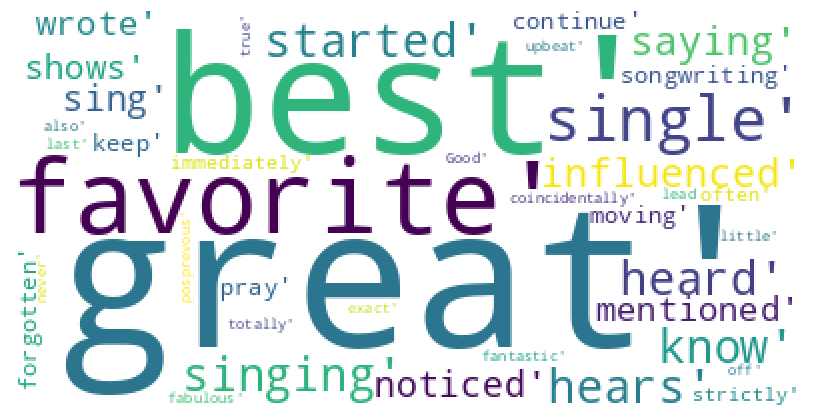

In [41]:
wordcloud = WordCloud(background_color="white").generate(str(get_sentiment_words_from_all_text_pos(products['B00000296B']['all_text_pos'])))

plt.figure(figsize = (8, 8))

plt.imshow(wordcloud); plt.axis("off")

plt.tight_layout(pad = 0); plt.show()

In [42]:
sentiment_features_vader = get_sentiment_features_vader(products)
sentiment_features_vader['B00000296B']

{'eStrength': 0.13872727272727273,
 'eRatio': 0.1981981981981982,
 'posToAllRatio': 0.9772727272727273}

In [43]:
sentiment_features = get_sentiment_features(products)
sentiment_features['B00000296B']

{'eStrength': 0.4669642857142857,
 'eRatio': 0.2972972972972973,
 'posToAllRatio': 0.9545454545454546}

In [44]:
sentiment_features = sentiment_features_vader

In [45]:
# Make sure that items in semantics have the same order of items in products
sentiment_features = {key: sentiment_features[key] for key in sorted(sentiment_features.keys())}
items = list(sentiment_features.items())
random.seed(42)
random.shuffle(items)
sentiment_features = dict(items)

In [46]:
sentiment_df = pd.DataFrame(sentiment_features)
sentiment_df = sentiment_df.transpose()
sentiment_df.head(10)

eStrength    eRatio  posToAllRatio
B0049P0A0W   0.085184  0.308756       0.940299
B000068R1R   0.104012  0.269841       0.985294
B000ML0EQC   0.068272  0.257576       0.970588
B0009I4770   0.065373  0.247573       0.941176
B001CMKNE8   0.018365  0.280453       0.929293
B000F903CG   0.028068  0.270876       0.977444
B000063KNI   0.015931  0.251634       0.876623
B001CY1Z7K   0.041341  0.208122       0.902439
B0002HM6A8   0.095913  0.212766       0.933333
B00D4CH3ZQ   0.034296  0.213415       0.980952

In [47]:
print(sentiment_df.head())

X_sent = sentiment_df

X_sent_train, X_sent_test, y_sent_train, y_sent_test = train_test_split(X_sent, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
scaler.fit(X_sent_train)

x_sent_train = scaler.transform(X_sent_train)
x_sent_test = scaler.transform(X_sent_test)

print(X_sent_train.shape)

            eStrength    eRatio  posToAllRatio
B0049P0A0W   0.085184  0.308756       0.940299
B000068R1R   0.104012  0.269841       0.985294
B000ML0EQC   0.068272  0.257576       0.970588
B0009I4770   0.065373  0.247573       0.941176
B001CMKNE8   0.018365  0.280453       0.929293
(640, 3)


# Classification Analysis - BOW
This section trains and evaluates different classifiers using the BOW features to predict the genre of music albums.

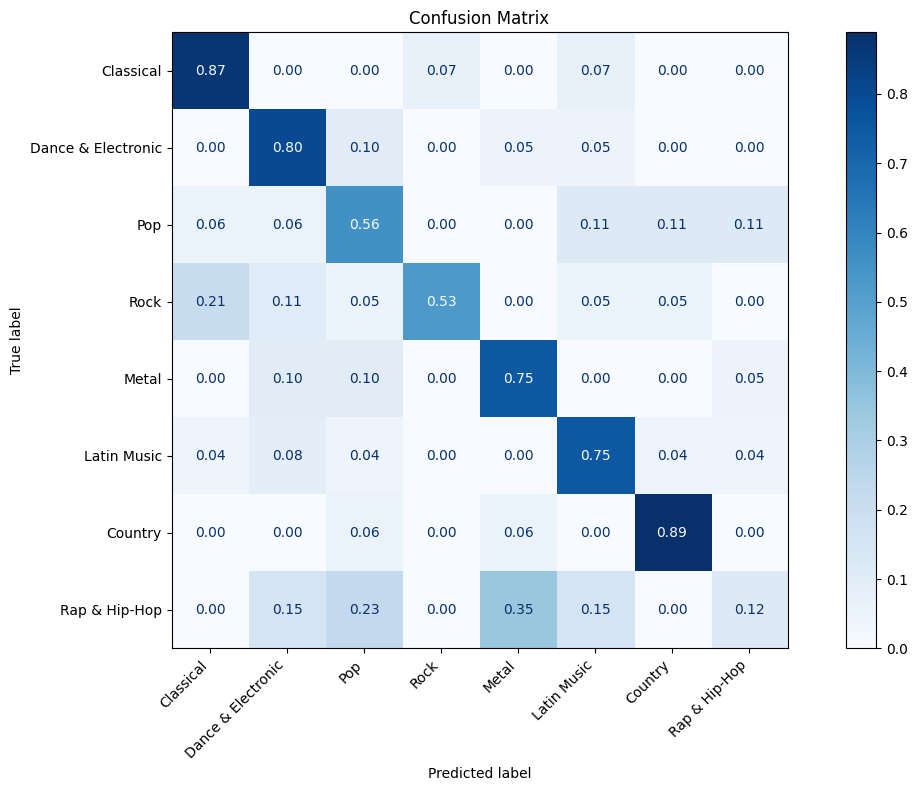

Logistic Regression Accuracy: 0.63


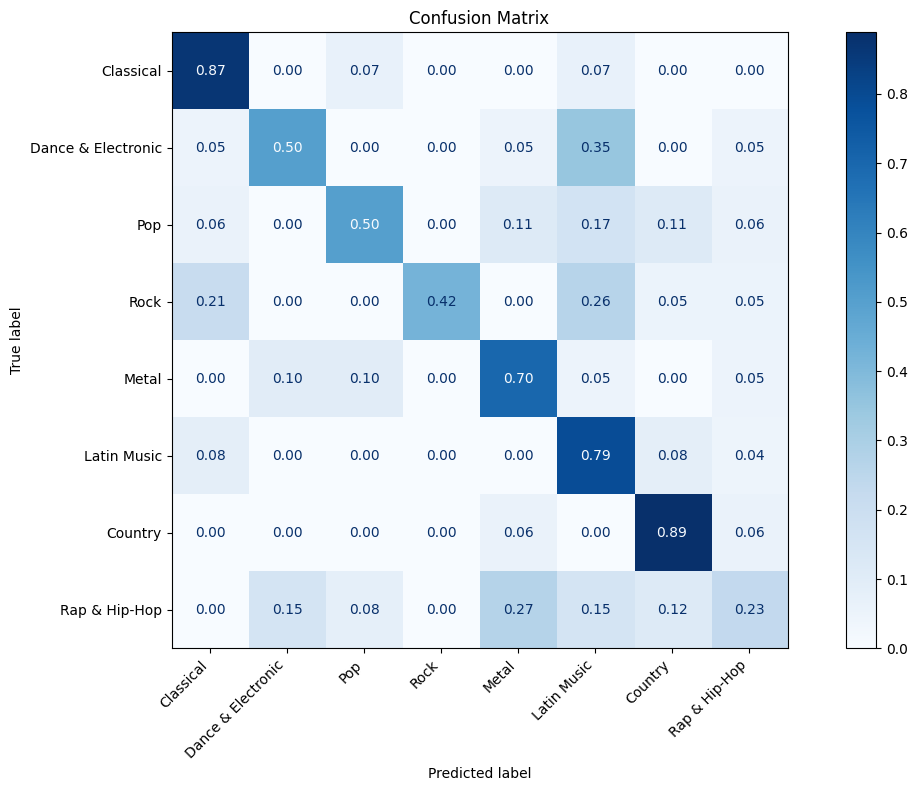

Random Forest Accuracy: 0.59


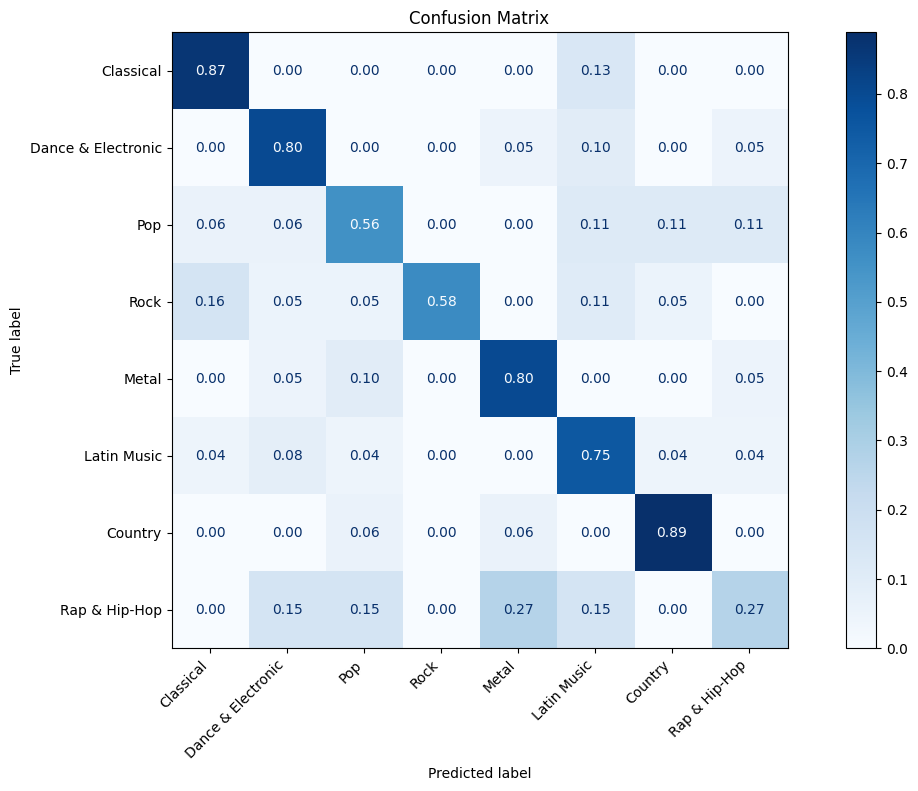

Linear SVM Accuracy: 0.67


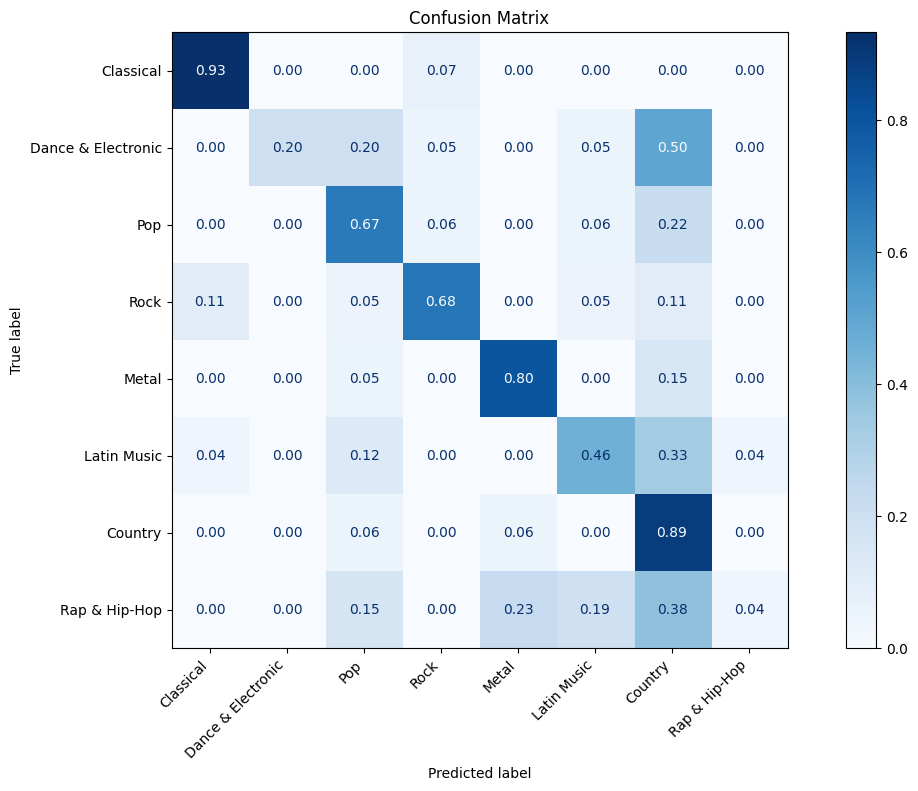

NN Accuracy: 0.54


In [48]:
# Initialize classifiers
logistic_regression = LogisticRegression(max_iter=1000)
random_forest = RandomForestClassifier(n_estimators=100)
linear_svm = LinearSVC(loss='squared_hinge', penalty="l2", dual=False, tol=1e-3)
neural_network = MLPClassifier(hidden_layer_sizes=(100,50), max_iter=500)


# Train and evaluate each classifier
def evaluate_model(model, x_train, y_train, x_test, y_test):
    model.fit(x_train, y_train)
    predictions = model.predict(x_test)
    accuracy = accuracy_score(y_test, predictions)
    plot_confusion_matrix(y_test, predictions, categories)
    return accuracy

def plot_confusion_matrix(y_true, y_pred, classes):
    cm = confusion_matrix(y_true, y_pred, normalize='true')
    fig, ax = plt.subplots(figsize=(15, 8))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
    disp.plot(cmap='Blues', values_format='.2f', ax=ax)
    plt.title('Confusion Matrix')
    _ = plt.xticks(rotation=45, ha='right')
    plt.show()

# Evaluate Logistic Regression
bow_accuracy_lr = evaluate_model(logistic_regression, X_bow_train, y_train, X_bow_test, y_test)
print(f"Logistic Regression Accuracy: {bow_accuracy_lr:.2f}")

# Evaluate Random Forest
bow_accuracy_rf = evaluate_model(random_forest, X_bow_train, y_train, X_bow_test, y_test)
print(f"Random Forest Accuracy: {bow_accuracy_rf:.2f}")

# Evaluate Linear SVM
bow_accuracy_svm = evaluate_model(linear_svm, X_bow_train, y_train, X_bow_test, y_test)
print(f"Linear SVM Accuracy: {bow_accuracy_svm:.2f}")

# Evaluate NN
bow_accuracy_nn = evaluate_model(neural_network, X_bow_train, y_train, X_bow_test, y_test)
print(f"NN Accuracy: {bow_accuracy_nn:.2f}")

# Classification Analysis - BOW, SEM

This section combines BOW and semantic features for classification and evaluates the models.

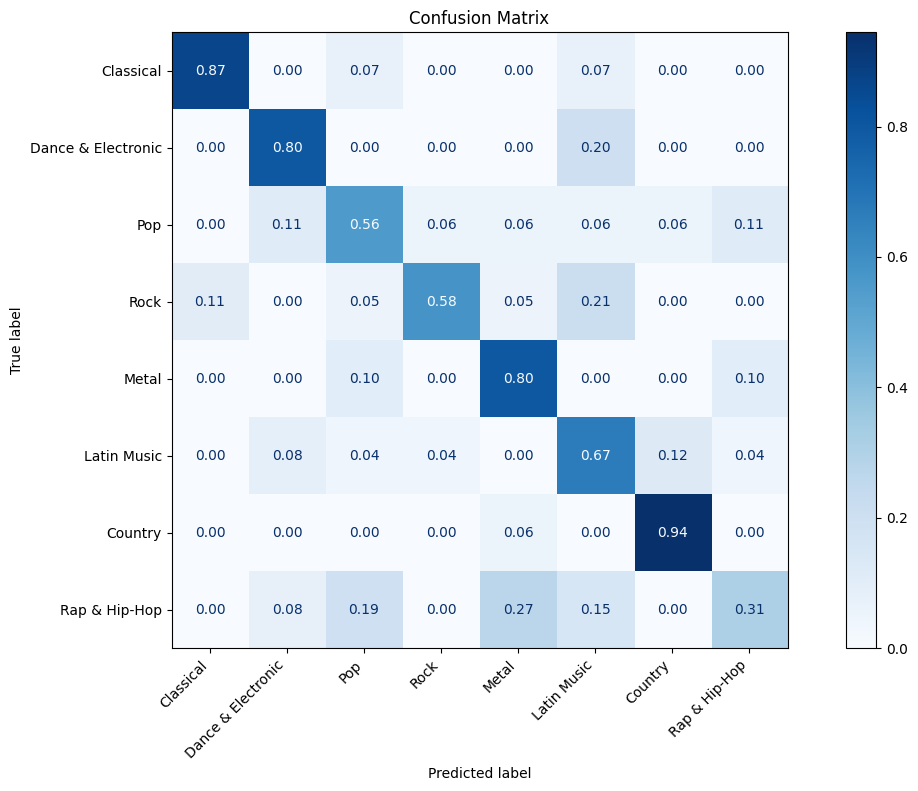

Logistic Regression Accuracy: 0.67


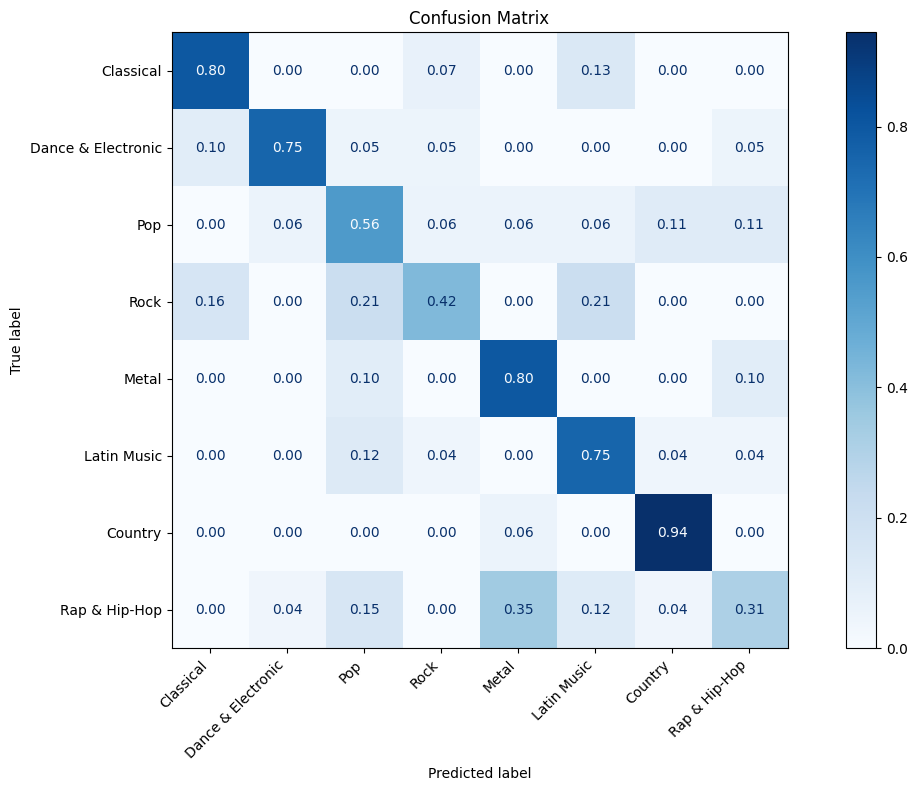

Random Forest Accuracy: 0.65


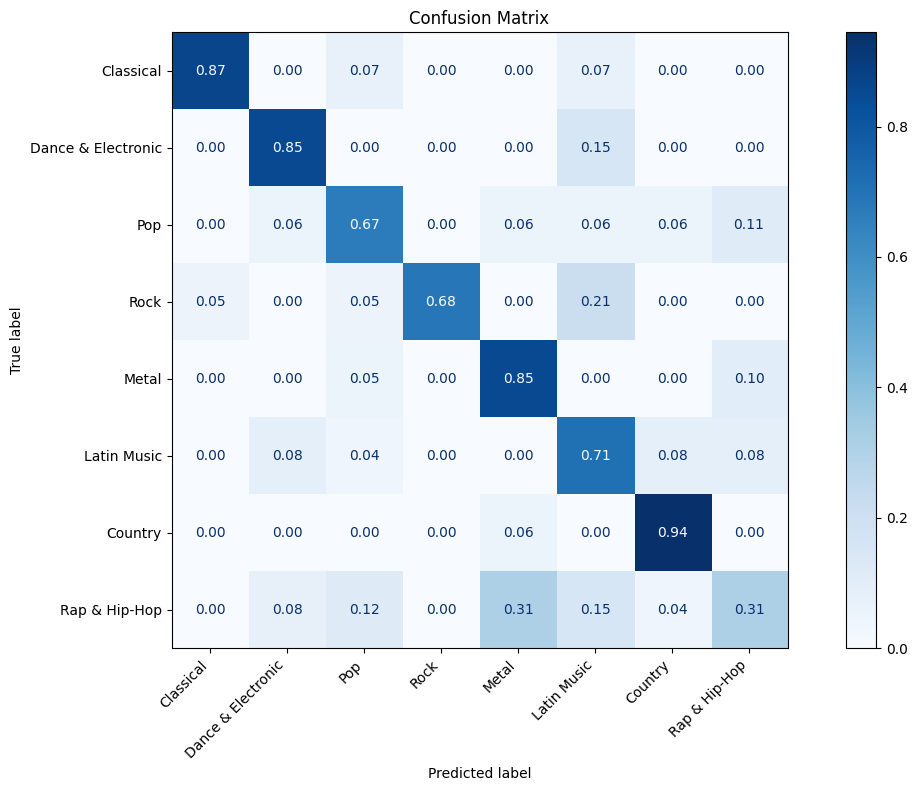

Linear SVM Accuracy: 0.71


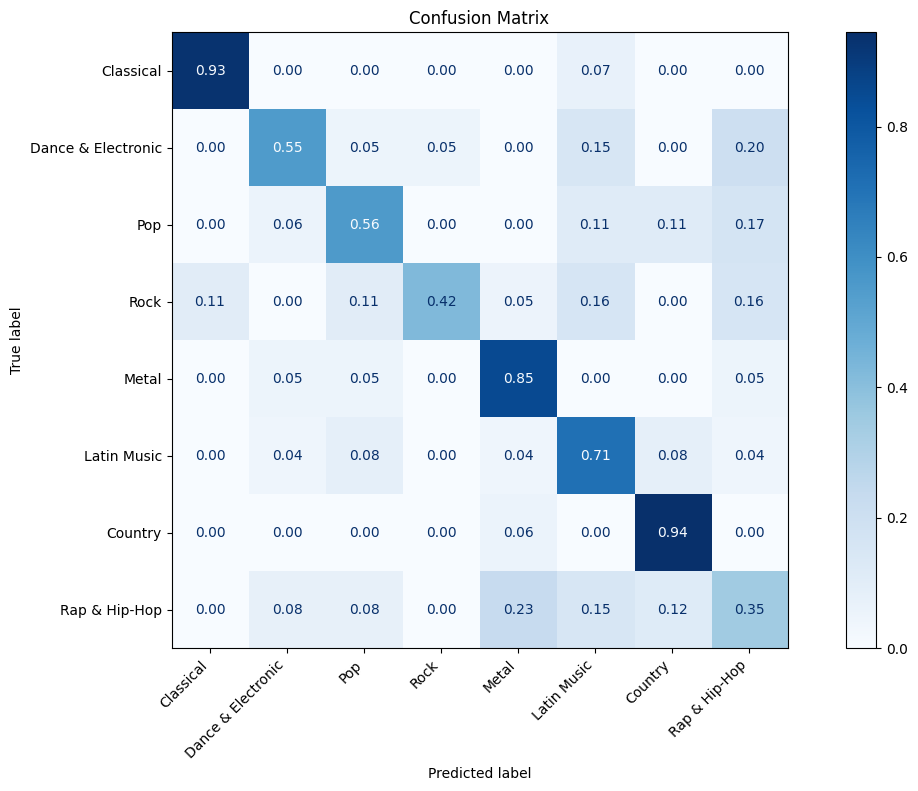

NN Accuracy: 0.64


In [49]:
X_bow_sem_train = hstack((X_bow_train,x_sem_train),format='csr')
X_bow_sem_test  = hstack((X_bow_test,x_sem_test),format='csr')

# Evaluate Logistic Regression
bow_sem_accuracy_lr = evaluate_model(logistic_regression, X_bow_sem_train, y_train, X_bow_sem_test, y_test)
print(f"Logistic Regression Accuracy: {bow_sem_accuracy_lr:.2f}")

# Evaluate Random Forest
bow_sem_accuracy_rf = evaluate_model(random_forest, X_bow_sem_train, y_train, X_bow_sem_test, y_test)
print(f"Random Forest Accuracy: {bow_sem_accuracy_rf:.2f}")

# Evaluate Linear SVM
bow_sem_accuracy_svm = evaluate_model(linear_svm, X_bow_sem_train, y_train, X_bow_sem_test, y_test)
print(f"Linear SVM Accuracy: {bow_sem_accuracy_svm:.2f}")

# Evaluate NN
bow_sem_accuracy_nn = evaluate_model(neural_network, X_bow_sem_train, y_train, X_bow_sem_test, y_test)
print(f"NN Accuracy: {bow_sem_accuracy_nn:.2f}")

# Classificatio Analysis - BOW, SENT

This section combines BOW and sentiment features for classification and evaluates the models.


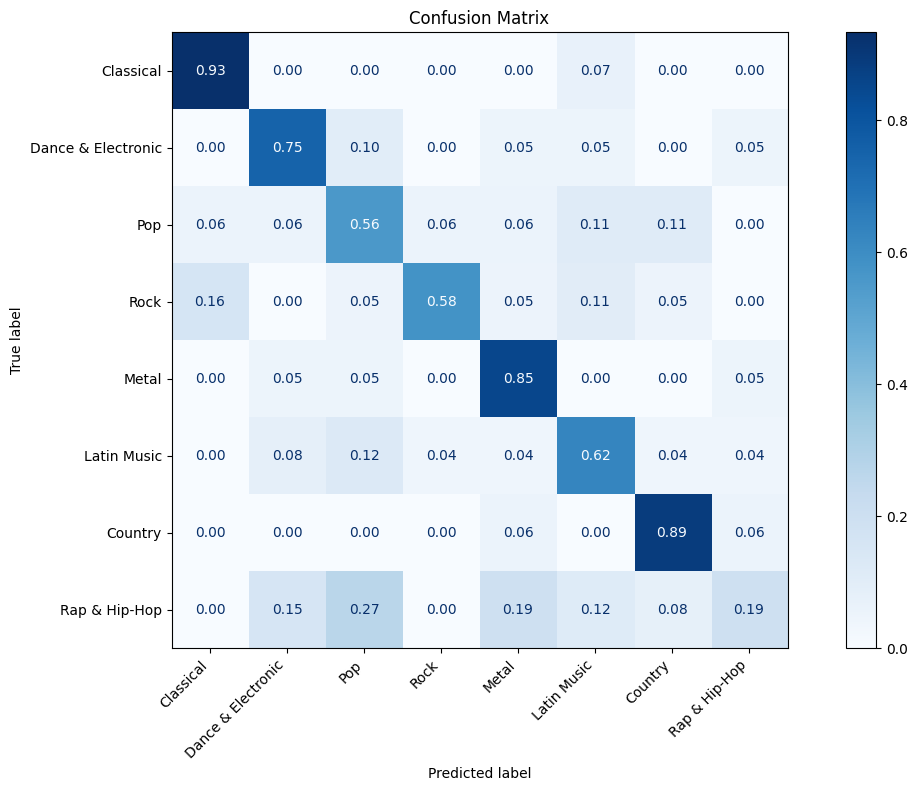

Logistic Regression Accuracy: 0.64


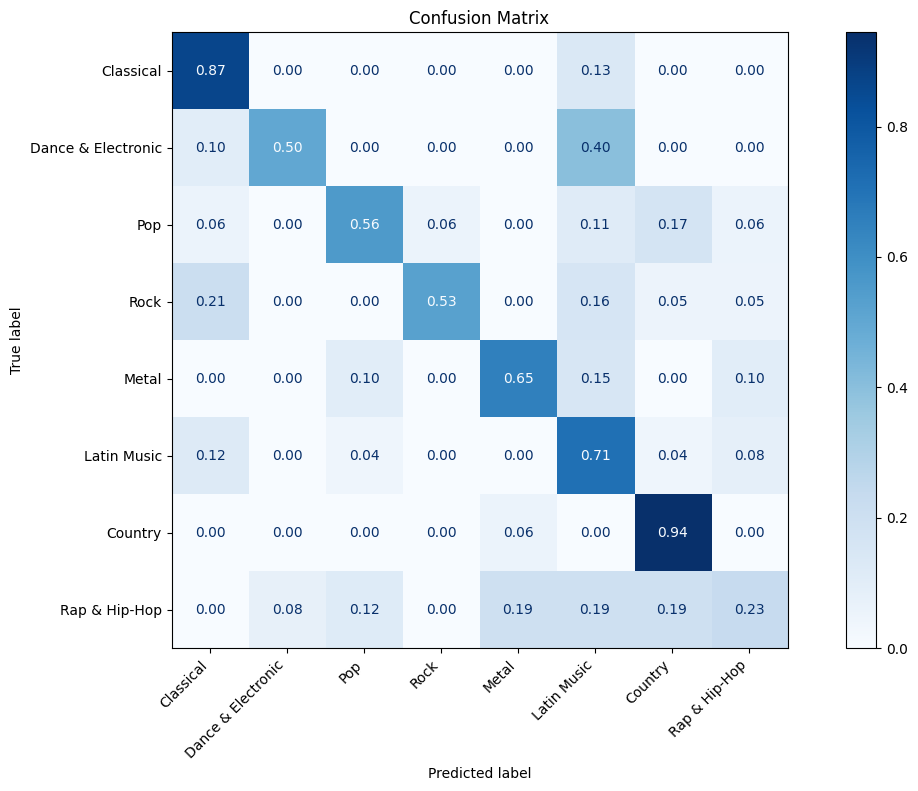

Random Forest Accuracy: 0.60


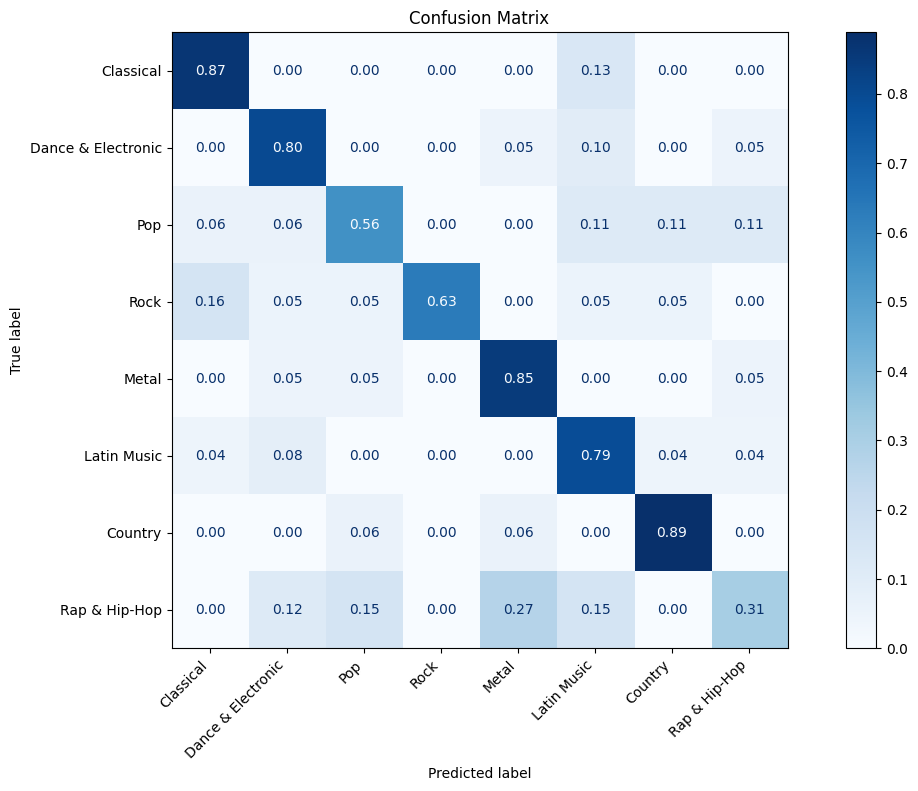

Linear SVM Accuracy: 0.69


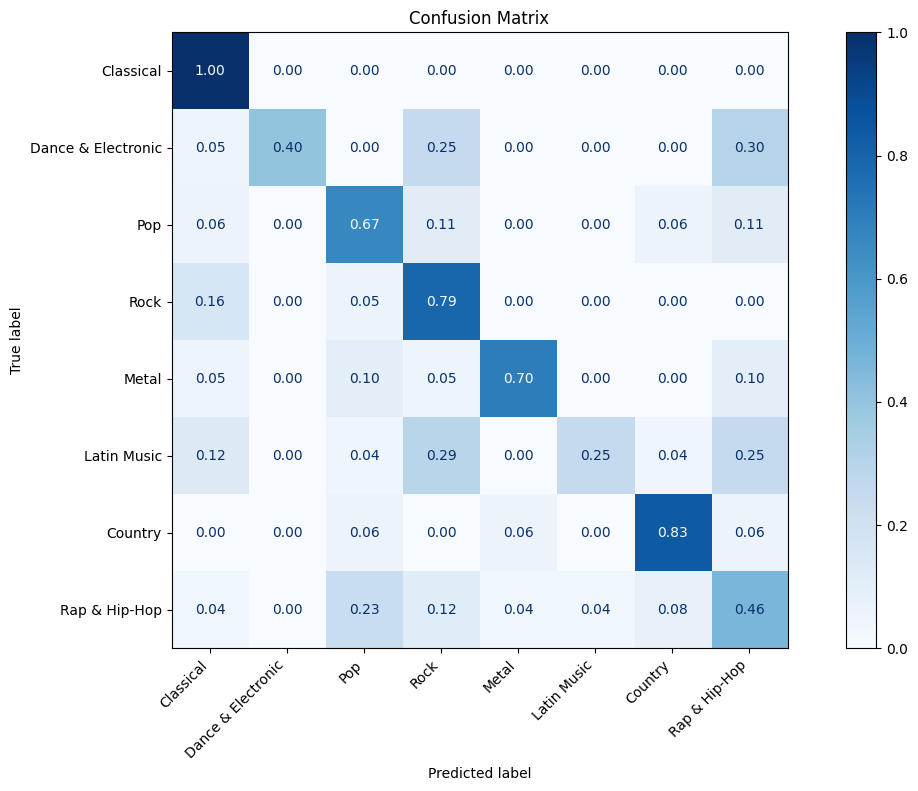

NN Accuracy: 0.69


In [50]:
X_bow_sent_train = hstack((X_bow_train,x_sent_train),format='csr')
X_bow_sent_test = hstack((X_bow_test,x_sent_test),format='csr')

# Evaluate Logistic Regression
bow_sent_accuracy_lr = evaluate_model(logistic_regression, X_bow_sent_train, y_train, X_bow_sent_test, y_test)
print(f"Logistic Regression Accuracy: {bow_sent_accuracy_lr:.2f}")

# Evaluate Random Forest
bow_sent_accuracy_rf = evaluate_model(random_forest, X_bow_sent_train, y_train, X_bow_sent_test, y_test)
print(f"Random Forest Accuracy: {bow_sent_accuracy_rf:.2f}")

# Evaluate Linear SVM
bow_sent_accuracy_svm = evaluate_model(linear_svm, X_bow_sent_train, y_train, X_bow_sent_test, y_test)
print(f"Linear SVM Accuracy: {bow_sent_accuracy_svm:.2f}")

# Evaluate NN
bow_sent_accuracy_nn = evaluate_model(neural_network, X_bow_sent_train, y_train, X_bow_sent_test, y_test)
print(f"NN Accuracy: {bow_sent_accuracy_svm:.2f}")

# Classification Analysis - BOW, SEM, SENT
This section combines BOW, semantic, and sentiment features for classification and evaluates the models.

Logistic Regression Accuracy: 0.69


Random Forest Accuracy: 0.65


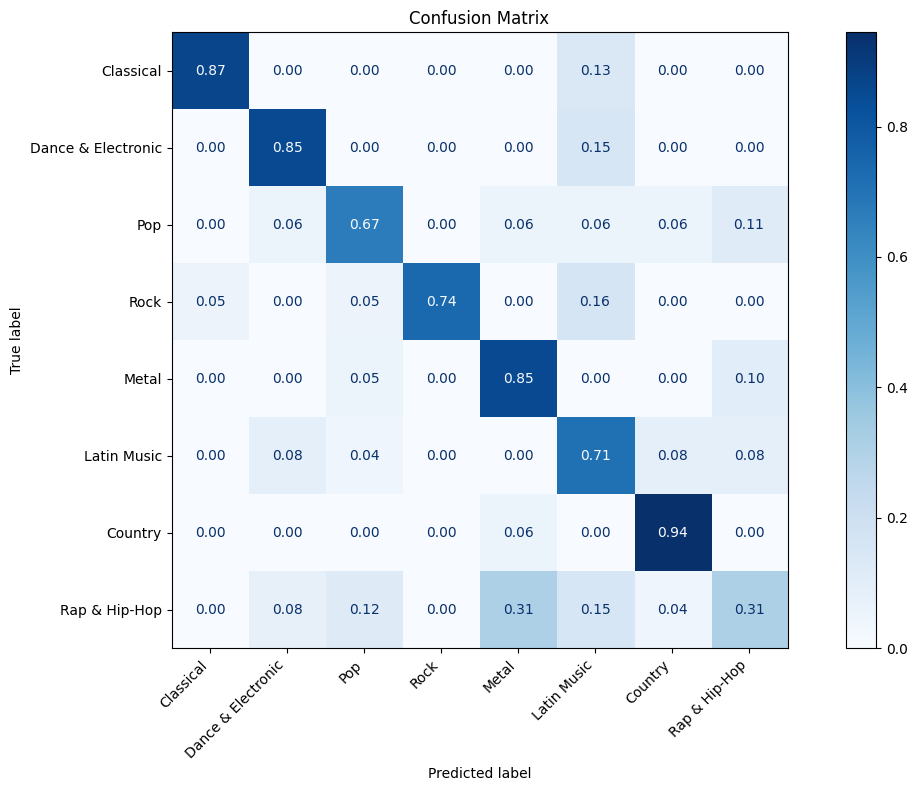

Linear SVM Accuracy: 0.72


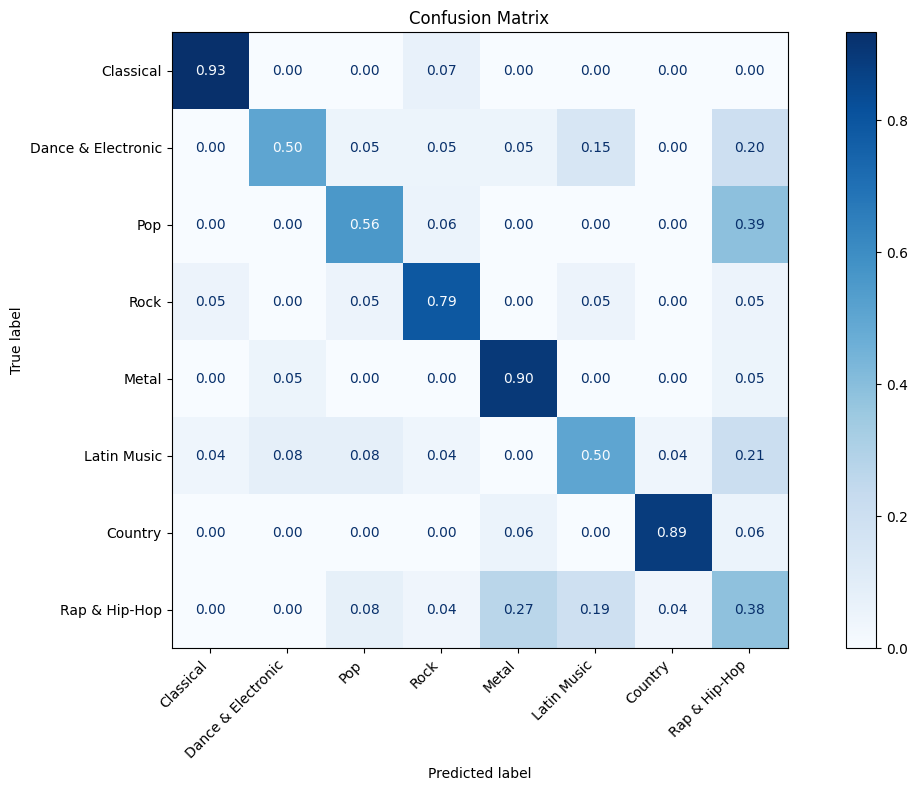

NN Accuracy: 0.72


In [51]:
X_bow_sem_sent_train = hstack((X_bow_train,x_sent_train, x_sem_train),format='csr')
X_bow_sem_sent_test = hstack((X_bow_test,x_sent_test, x_sem_test),format='csr')

# Evaluate Logistic Regression
bow_sem_sent_accuracy_lr = evaluate_model(logistic_regression, X_bow_sem_sent_train, y_train, X_bow_sem_sent_test, y_test)
print(f"Logistic Regression Accuracy: {bow_sem_sent_accuracy_lr:.2f}")

# Evaluate Random Forest
bow_sem_sent_accuracy_rf = evaluate_model(random_forest, X_bow_sem_sent_train, y_train, X_bow_sem_sent_test, y_test)
print(f"Random Forest Accuracy: {bow_sem_sent_accuracy_rf:.2f}")

# Evaluate Linear SVM
bow_sem_sent_accuracy_svm = evaluate_model(linear_svm, X_bow_sem_sent_train, y_train, X_bow_sem_sent_test, y_test)
print(f"Linear SVM Accuracy: {bow_sem_sent_accuracy_svm:.2f}")

# Evaluate NN
bow_sem_sent_accuracy_nn = evaluate_model(neural_network, X_bow_sem_sent_train, y_train, X_bow_sem_sent_test, y_test)
print(f"NN Accuracy: {bow_sem_sent_accuracy_svm:.2f}")

In [52]:
# Evaluate classifiers and combine results
results_combined = []

# Evaluate classifiers for X_bow
results_combined.append(['Logistic Regression', 'X_bow', f"{bow_accuracy_lr:.2f}"])
results_combined.append(['Random Forest', 'X_bow', f"{bow_accuracy_rf:.2f}"])
results_combined.append(['Linear SVM', 'X_bow', f"{bow_accuracy_svm:.2f}"])
results_combined.append(['NN', 'X_bow', f"{bow_accuracy_nn:.2f}"])

# Evaluate classifiers for X_sem
results_combined.append(['Logistic Regression', 'X_bow_sem', f"{bow_sem_accuracy_lr:.2f}"])
results_combined.append(['Random Forest', 'X_bow_sem', f"{bow_sem_accuracy_rf:.2f}"])
results_combined.append(['Linear SVM', 'X_bow_sem', f"{bow_sem_accuracy_svm:.2f}"])
results_combined.append(['NN', 'X_bow_sem', f"{bow_sem_accuracy_nn:.2f}"])

# Evaluate classifiers for X_bow_sent
results_combined.append(['Logistic Regression', 'X_bow_sent', f"{bow_sent_accuracy_lr:.2f}"])
results_combined.append(['Random Forest', 'X_bow_sent', f"{bow_sent_accuracy_rf:.2f}"])
results_combined.append(['Linear SVM', 'X_bow_sent', f"{bow_sent_accuracy_svm:.2f}"])
results_combined.append(['NN', 'X_bow_sent', f"{bow_sent_accuracy_nn:.2f}"])

# Evaluate classifiers for X_bow_sem_sent
results_combined.append(['Logistic Regression', 'X_bow_sem_sent', f"{bow_sem_sent_accuracy_lr:.2f}"])
results_combined.append(['Random Forest', 'X_bow_sem_sent', f"{bow_sem_sent_accuracy_rf:.2f}"])
results_combined.append(['Linear SVM', 'X_bow_sem_sent', f"{bow_sem_sent_accuracy_svm:.2f}"])
results_combined.append(['NN', 'X_bow_sem_sent', f"{bow_sem_sent_accuracy_nn:.2f}"])


In [53]:
# Create a table using pandas
results_df = pd.DataFrame(results_combined, columns=['Classifier', 'Dataset', 'Accuracy'])
results_pivot = results_df.pivot(index='Classifier', columns='Dataset', values='Accuracy')

# Display the table
print(tabulate(results_pivot, headers='keys', tablefmt='grid'))

+---------------------+---------+-------------+------------------+--------------+
| Classifier          |   X_bow |   X_bow_sem |   X_bow_sem_sent |   X_bow_sent |
+=====================+=========+=============+==================+==============+
| Linear SVM          |    0.67 |        0.71 |             0.72 |         0.69 |
+---------------------+---------+-------------+------------------+--------------+
| Logistic Regression |    0.63 |        0.67 |             0.69 |         0.64 |
+---------------------+---------+-------------+------------------+--------------+
| NN                  |    0.54 |        0.64 |             0.66 |         0.61 |
+---------------------+---------+-------------+------------------+--------------+
| Random Forest       |    0.59 |        0.65 |             0.65 |         0.6  |
+---------------------+---------+-------------+------------------+--------------+


In [54]:
fig, ax = plt.subplots(figsize=(8, 4))
ax.axis('tight')
ax.axis('off')
table = ax.table(cellText=results_pivot.values,
                 colLabels=results_pivot.columns,
                 rowLabels=results_pivot.index,
                 cellLoc='center',
                 loc='center')
table.auto_set_font_size(False)
table.set_fontsize(10)
table.auto_set_column_width(col=list(range(len(results_pivot.columns))))
plt.show()

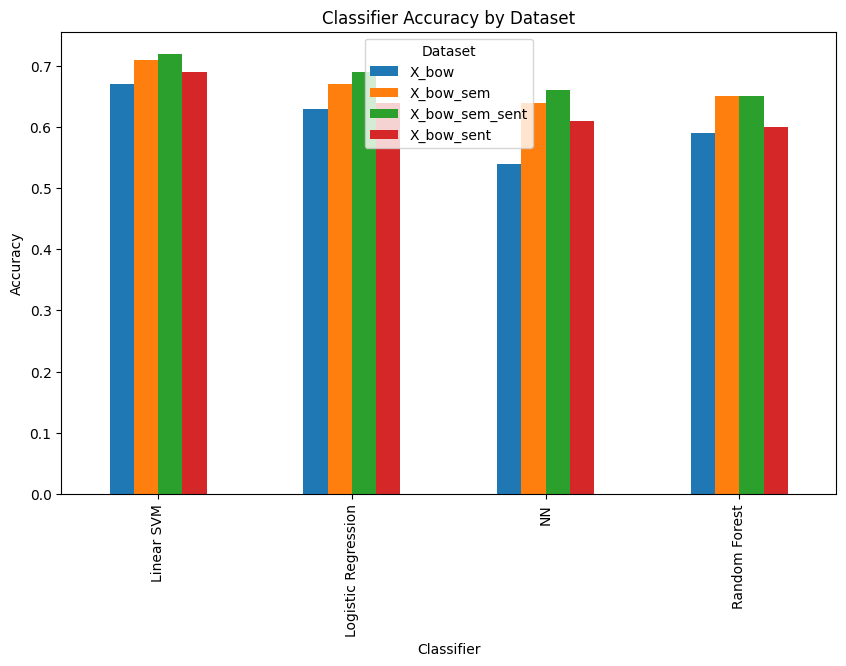

In [55]:
results_df = pd.DataFrame(results_combined, columns=['Classifier', 'Dataset', 'Accuracy'])
results_df['Accuracy'] = pd.to_numeric(results_df['Accuracy'])  # Convert 'Accuracy' column to numeric
results_pivot = results_df.pivot(index='Classifier', columns='Dataset', values='Accuracy')

# Plotting
results_pivot.plot(kind='bar', figsize=(10, 6))
plt.ylabel('Accuracy')
plt.title('Classifier Accuracy by Dataset')
plt.legend(title='Dataset')

# Show plot
plt.show()

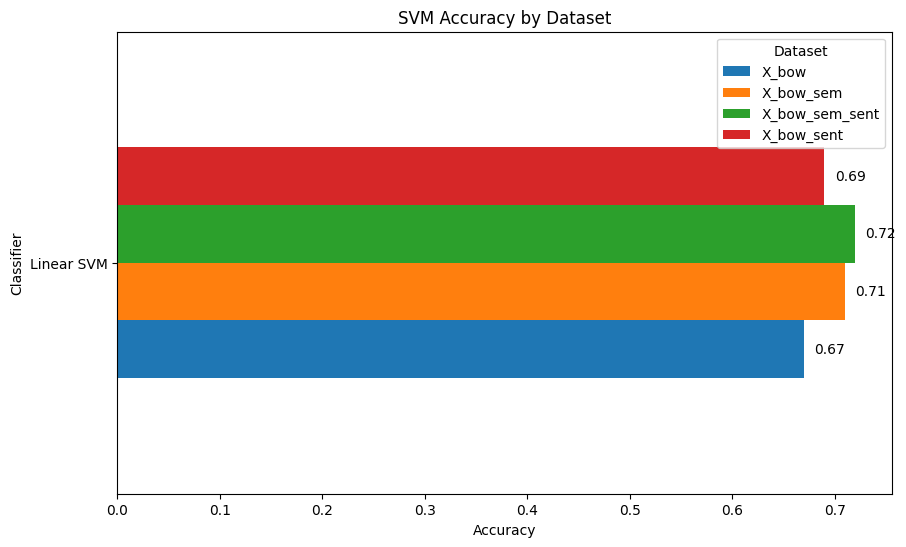

In [56]:
results_df = pd.DataFrame(results_combined, columns=['Classifier', 'Dataset', 'Accuracy'])
results_df['Accuracy'] = pd.to_numeric(results_df['Accuracy'])  # Convert 'Accuracy' column to numeric
results_pivot = results_df.pivot(index='Classifier', columns='Dataset', values='Accuracy')

# Filter for Ridge Classifier
svm_classifier_results = results_pivot.loc[['Linear SVM']]

# Plotting horizontally with accuracy values on bars
ax = svm_classifier_results.plot(kind='barh', figsize=(10, 6))
plt.xlabel('Accuracy')
plt.title('SVM Accuracy by Dataset')
plt.legend(title='Dataset')

# Add accuracy values on bars
for p in ax.patches:
    ax.annotate(f'{p.get_width():.2f}', (p.get_width() + 0.01, p.get_y() + p.get_height() / 2),
                ha='left', va='center', fontsize=10)

# Show plot
plt.show()

In [57]:
# Create a list of POS tag sequences for each product
X_pos = products_df['all_pos'].tolist()
print(X_pos)
# Initialize a TF-IDF vectorizer
pos_vectorizer = TfidfVectorizer(sublinear_tf=True, max_df=0.5, stop_words='english')

# Create TF-IDF features for POS tags
X_pos_train, X_pos_test, _, _ = train_test_split(X_pos, y, test_size=0.2, random_state=42)

X_pos_train = pos_vectorizer.fit_transform(X_pos_train)
X_pos_test = pos_vectorizer.transform(X_pos_test)

# Combine features (BOW, Sentiment, POS)
X_combined_train = hstack((X_bow_train, x_sent_train, X_pos_train), format='csr')
X_combined_test = hstack((X_bow_test, x_sent_test, X_pos_test), format='csr')

# Initialize and train your classifier (e.g., Logistic Regression)
logistic_regression = LogisticRegression(max_iter=1000)
logistic_regression.fit(X_combined_train, y_train)

# Make predictions and evaluate
predictions = logistic_regression.predict(X_combined_test)
accuracy = accuracy_score(y_test, predictions)
print(f"Accuracy with POS features: {accuracy:.2f}")

['IN VBG TO DT NN IN DT NN NNS IN DT NN NNS NN PRP VBD JJ TO VB DT NN PRP VBD RB VBN DT NNS IN NN RB IN DT JJ NNS CC PRP VBD JJ RB RB IN NN VBZ NN POS NN VB TO DT NN IN DT NN IN DT JJ NNS PRP NN DT NN NN PRP VBD JJ NN EX VBD NN POS NN RB NN IN VBD PRP JJ NNS RB DT NN MD VB JJR TO PRP$ NN RB NN POS  DT NN IN NNS RB NN VBD PRP DT VBZ IN DT NN NNS NNS NNS IN NNS CC NN NN IN NN CC NN NN IN NN PRP VBD PRP$ CD NN DT NN PRP VBD RB VBN CC RB VBD DT NN IN DT NN RB JJ NN DT NN IN PRP$ CD NN IN DT NNS VBD IN DT NN NN PRP VBD IN DT NN EX VBD IN JJ NN NN NN PRP VBD PRP VBD IN CC VBD DT JJ NN VB JJ NN IN IN NN CC DT JJS NN NN CC PRP POS NN RB IN VBN IN PRP VBD IN NN DT NN IN DT CD NN EX VBP NNS IN DT DT VBZ DT NN RB IN NNS VBZ VB NNS PRP$ JJ NNS VBP RB VBG DT JJ JJ NNS EX VBP RB JJ NNS RB TO NN PRP IN DT NNS MD VB IN DT JJS DT CD NNS VBP VBN VBG IN CD NNS RB CC RB VBP DT JJ NN TO RBS NNS NNP VBZ DT NN IN VBG DT NN NN IN JJ JJ NNS IN PRP$ NN DT VBZ JJR IN DT IN NN NN RB IN DT RB NNS IN MD VB PRP$ NNS

In [58]:
# Evaluate classifiers for X_bow_sem_sent
results_combined.append(['Logistic Regression', 'X_bow_pos', f"{evaluate_model(logistic_regression, X_combined_train, y_train, X_combined_test, y_test):.2f}"])
results_combined.append(['Random Forest', 'X_bow_pos', f"{evaluate_model(random_forest, X_combined_train, y_train, X_combined_test, y_test):.2f}"])
results_combined.append(['Linear SVM', 'X_bow_pos', f"{evaluate_model(linear_svm, X_combined_train, y_train, X_combined_test, y_test):.2f}"])

In [59]:
# Create a table using pandas
results_df = pd.DataFrame(results_combined, columns=['Classifier', 'Dataset', 'Accuracy'])
results_pivot = results_df.pivot(index='Classifier', columns='Dataset', values='Accuracy')

# Display the table
print(tabulate(results_pivot, headers='keys', tablefmt='grid'))

+---------------------+---------+-------------+-------------+------------------+--------------+
| Classifier          |   X_bow |   X_bow_pos |   X_bow_sem |   X_bow_sem_sent |   X_bow_sent |
+=====================+=========+=============+=============+==================+==============+
| Linear SVM          |    0.67 |        0.66 |        0.71 |             0.72 |         0.69 |
+---------------------+---------+-------------+-------------+------------------+--------------+
| Logistic Regression |    0.63 |        0.45 |        0.67 |             0.69 |         0.64 |
+---------------------+---------+-------------+-------------+------------------+--------------+
| NN                  |    0.54 |      nan    |        0.64 |             0.66 |         0.61 |
+---------------------+---------+-------------+-------------+------------------+--------------+
| Random Forest       |    0.59 |        0.56 |        0.65 |             0.65 |         0.6  |
+---------------------+---------+-------

# Modeling and Evaluation

### Models Tested:
1. Logistic Regression
2. Random Forest
3. Linear SVM
4. Neural Networks

### Results:
- **Best Performing Model**: Linear SVM with semantic and sentiment features.
  - **Accuracy**: 72%
- Sentiment features alone slightly improved classification compared to Bag-of-Words.



# Finetuning Hyperparams

In [60]:
lr_exploration  = False
svm_exploration = False
rf_exploration  = False
nn_exploration  = False

if lr_exploration:

    print("Logistic Regression Exploration start")
    print(" ")

    param_grid = {
        'C': [0.1, 1, 10],
        'penalty': ['l1', 'l2'],
        'solver': ['liblinear', 'saga']  # Both support 'l1' and 'l2'
    }

    grid_search = GridSearchCV(logistic_regression, param_grid, cv=5)
    grid_search.fit(X_bow_train, y_train)
    best_model = grid_search.best_estimator_

    print("Best Parameters for Logistic Regression:", grid_search.best_params_)
    print("Best Cross-Validation Score for Logistic Regression:", grid_search.best_score_)
    print("Logistic Regression Exploration Stop")
    print(" ")

    print("Linear SVC Exploration start")
    print(" ")

if svm_exploration:

    # Define LinearSVC with fixed settings
    linear_svm = LinearSVC(dual=False, max_iter=1000)

    # Define the parameter grid for tuning
    svm_param_grid = {
        'C': [0.01, 0.1, 1, 10, 100],               # Regularization strength
        'loss': ['hinge', 'squared_hinge'],         # Loss functions
        'tol': [1e-4, 1e-3, 1e-2],                  # Tolerance for stopping criteria
        'penalty': ['l1', 'l2']                     # Penalty term
    }

    # Perform Grid Search
    svm_grid_search = GridSearchCV(linear_svm, svm_param_grid, cv=5, scoring='accuracy')
    svm_grid_search.fit(X_bow_train, y_train)

    # Display best parameters and score
    print("Linear SVM Best Parameters:", svm_grid_search.best_params_)
    print("Linear SVM Best Score:", svm_grid_search.best_score_)
    print("Linear SVC Exploration stop")
    print(" ")

if rf_exploration:

    print("Random Forest Exploration start")
    print(" ")

    # Define Random Forest and parameter grid
    random_forest = RandomForestClassifier()
    rf_param_grid = {
        'n_estimators': [50, 100, 200],
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    }

    # Perform Grid Search
    rf_grid_search = GridSearchCV(random_forest, rf_param_grid, cv=5, scoring='accuracy')
    rf_grid_search.fit(X_bow_train, y_train)

    # Best parameters and score
    print("Random Forest Best Parameters:", rf_grid_search.best_params_)
    print("Random Forest Best Score:", rf_grid_search.best_score_)

    print("Random Forest Exploration stop")
    print(" ")

if nn_exploration:

    # Reduced parameter grid for RandomizedSearchCV
    param_distributions = {
        'hidden_layer_sizes': [(100, 50), (100, 50,25), (100, 75, 50, 25), (100, 100, 50, 50), (100, 75, 50, 25, 10) ],
        'activation': ['relu', 'tanh'],  # Common choices
        'solver': ['adam'],  # Focused on the best-performing solver
        'alpha': uniform(0.0001, 0.01),  # Sample from a continuous range
        'learning_rate': ['adaptive'],  # Popular option for MLP
        'max_iter': [200, 300]  # Limited iterations to reduce time
    }

    # Initialize MLPClassifier with early stopping
    neural_network = MLPClassifier(early_stopping=True, warm_start=True)

    # RandomizedSearchCV with parallel processing and reduced iterations
    randomized_search = RandomizedSearchCV(
        estimator=neural_network,
        param_distributions=param_distributions,
        n_iter=30,  # Randomly sample 30 combinations
        cv=3,  # Fewer folds to save time
        scoring='accuracy',
        verbose=2,
        n_jobs=-1,  # Utilize all available CPU cores
        random_state=42
    )

    # Train on a subset of the data (optional: comment out if using full data)
    subset_indices = np.random.choice(X_bow_train.shape[0], size=min(5000, X_bow_train.shape[0]), replace=False)
    X_subset, y_subset = X_bow_train[subset_indices], y_train[subset_indices]

    # Perform hyperparameter tuning on the subset
    randomized_search.fit(X_subset, y_subset)

    # Display results
    print("Best Parameters:", randomized_search.best_params_)
    print("Best Score:", randomized_search.best_score_)

    # Evaluate the best model on the full test set
    best_model = randomized_search.best_estimator_
    accuracy = evaluate_model(best_model, X_bow_train, y_train, X_bow_test, y_test)  # Replace with your evaluation function
    print(f"Optimized Neural Network Accuracy: {accuracy:.2f}")

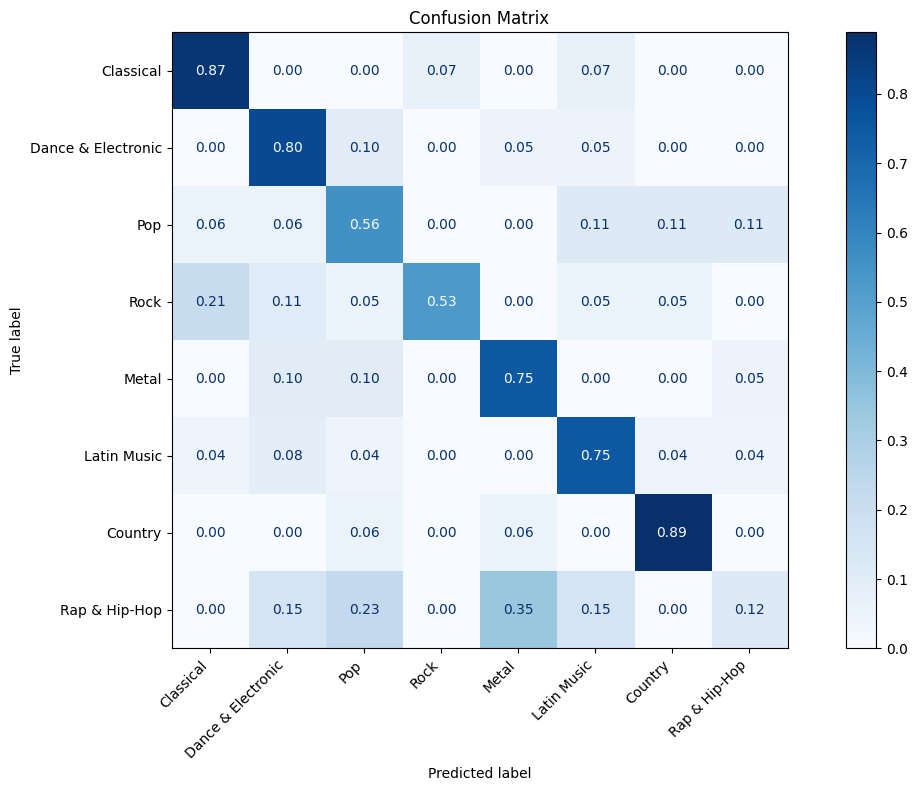

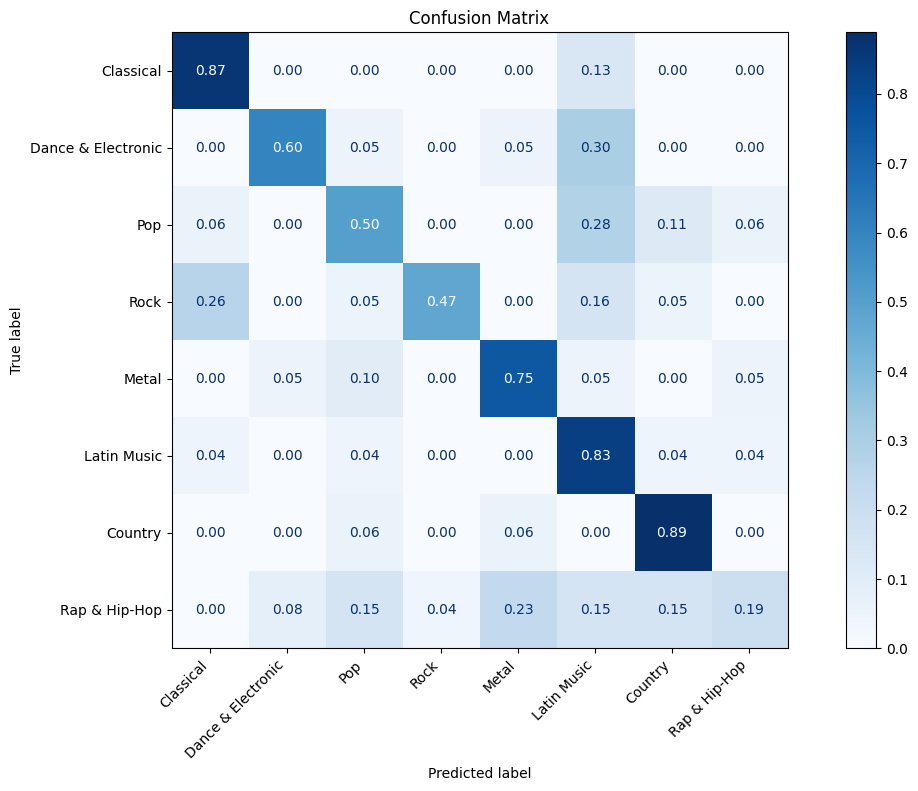

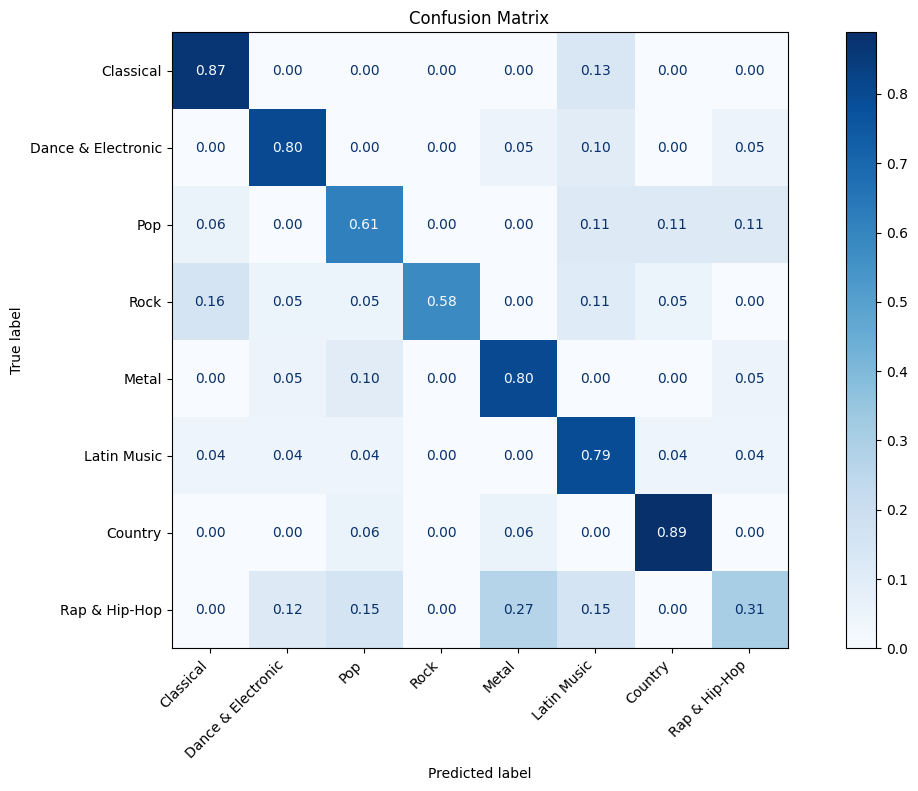

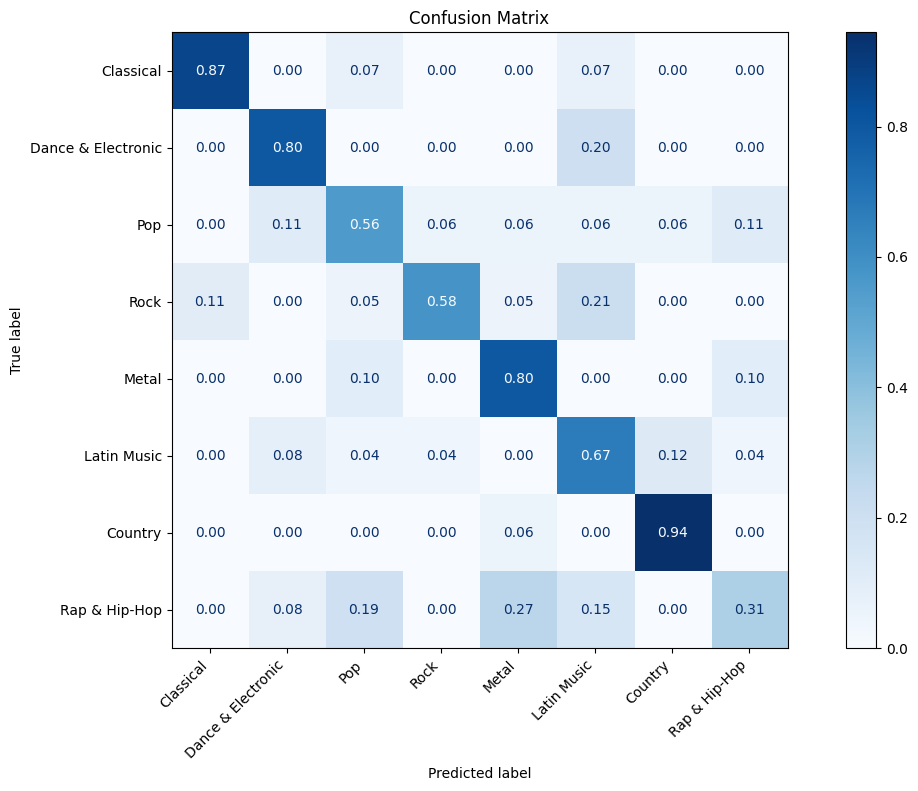

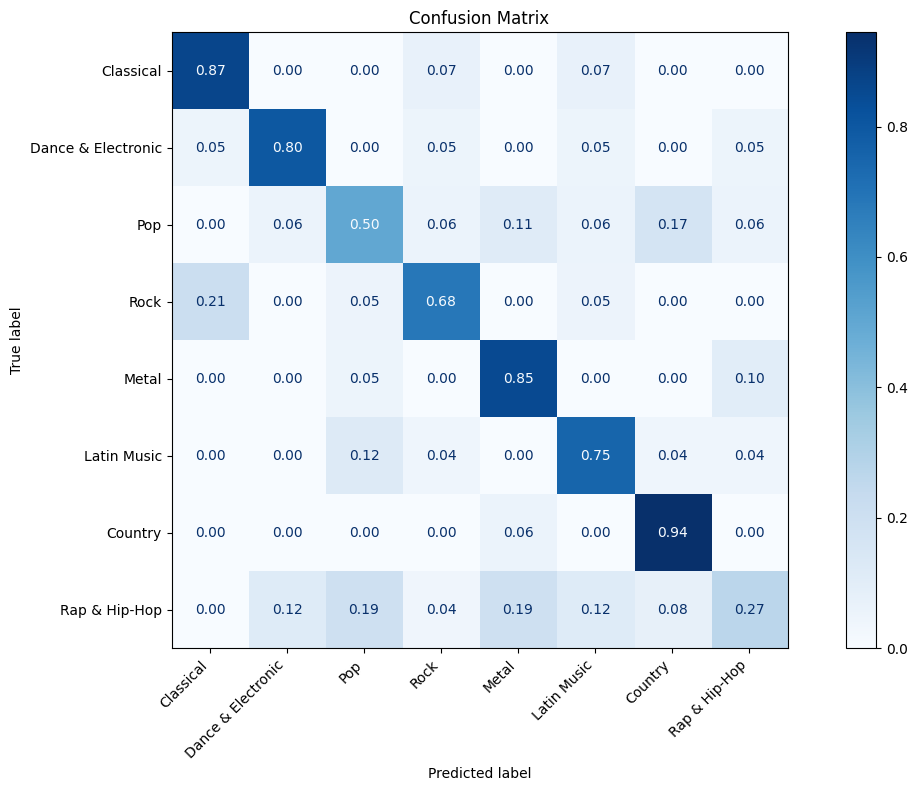

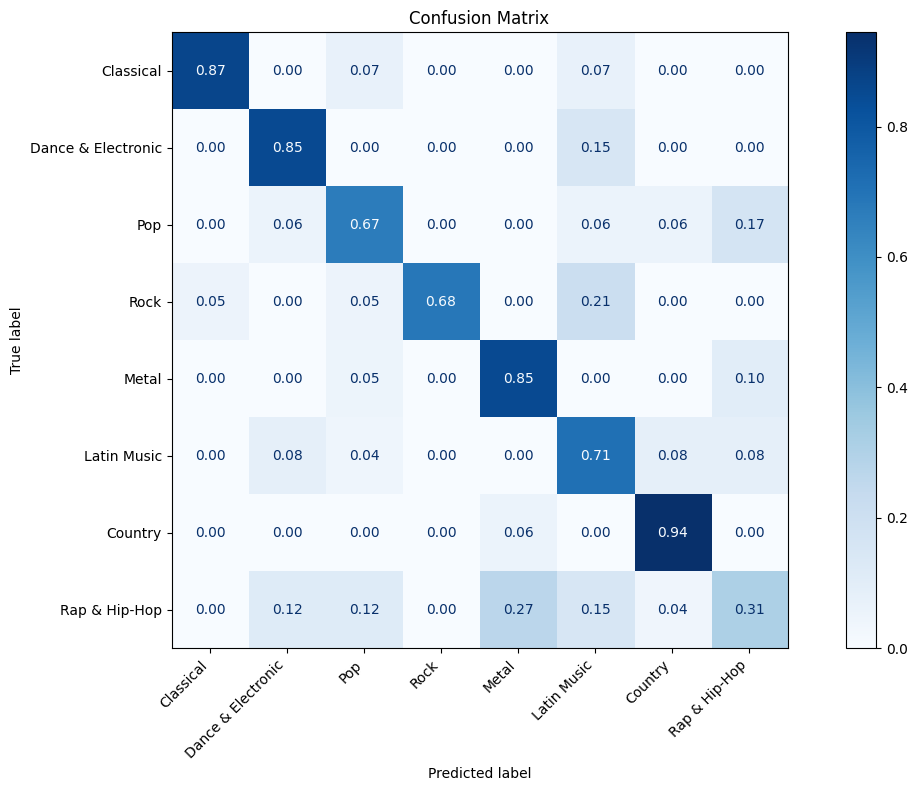

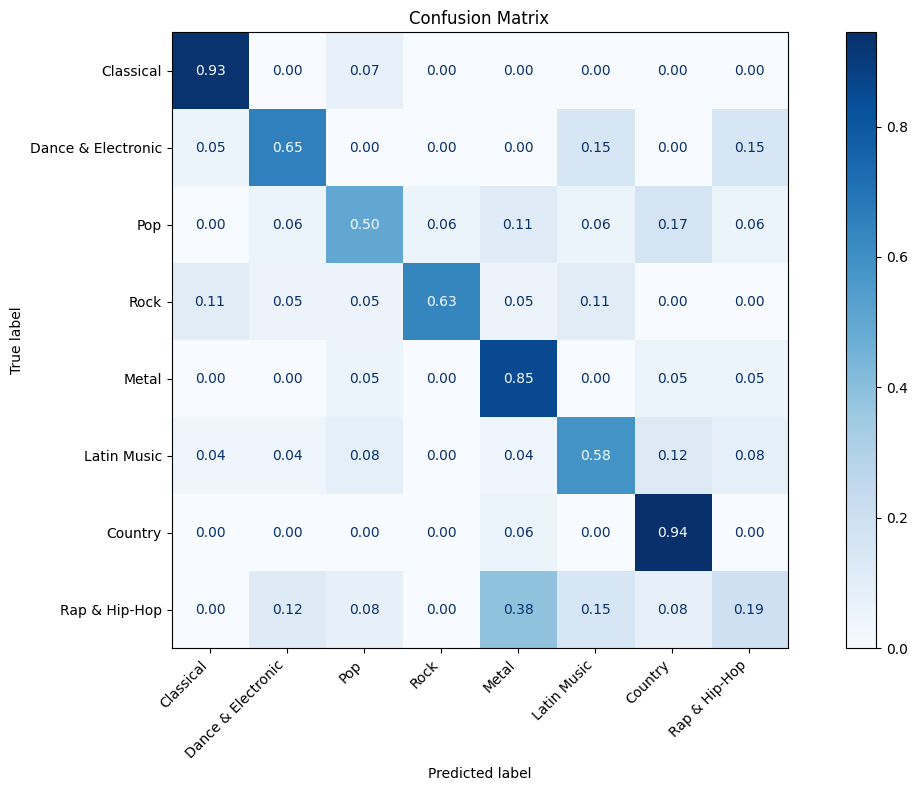

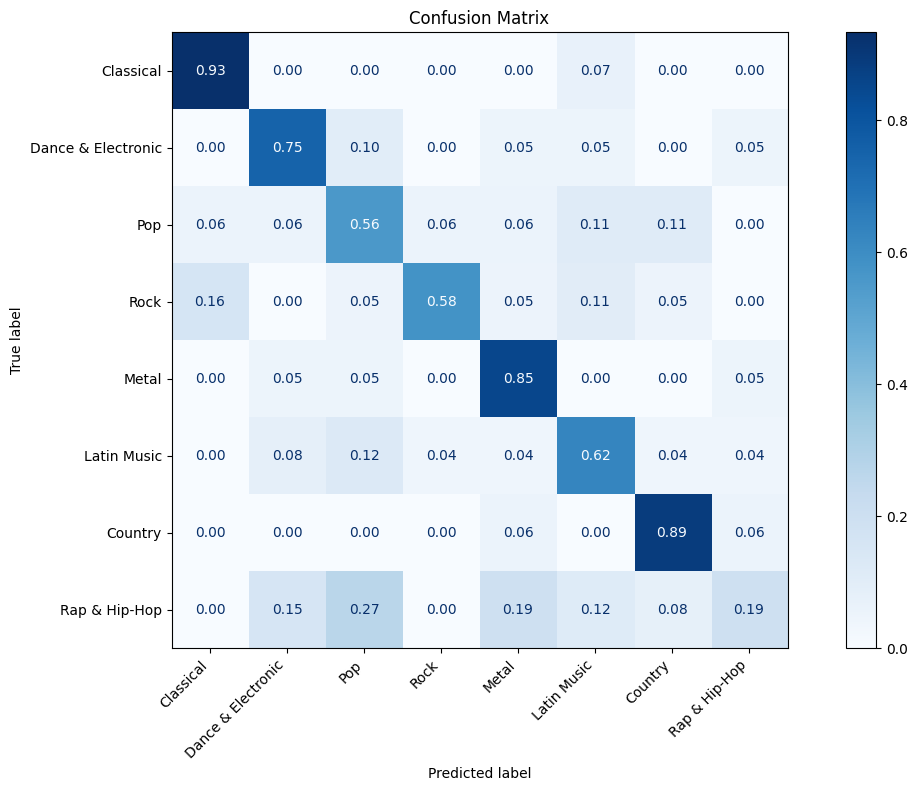

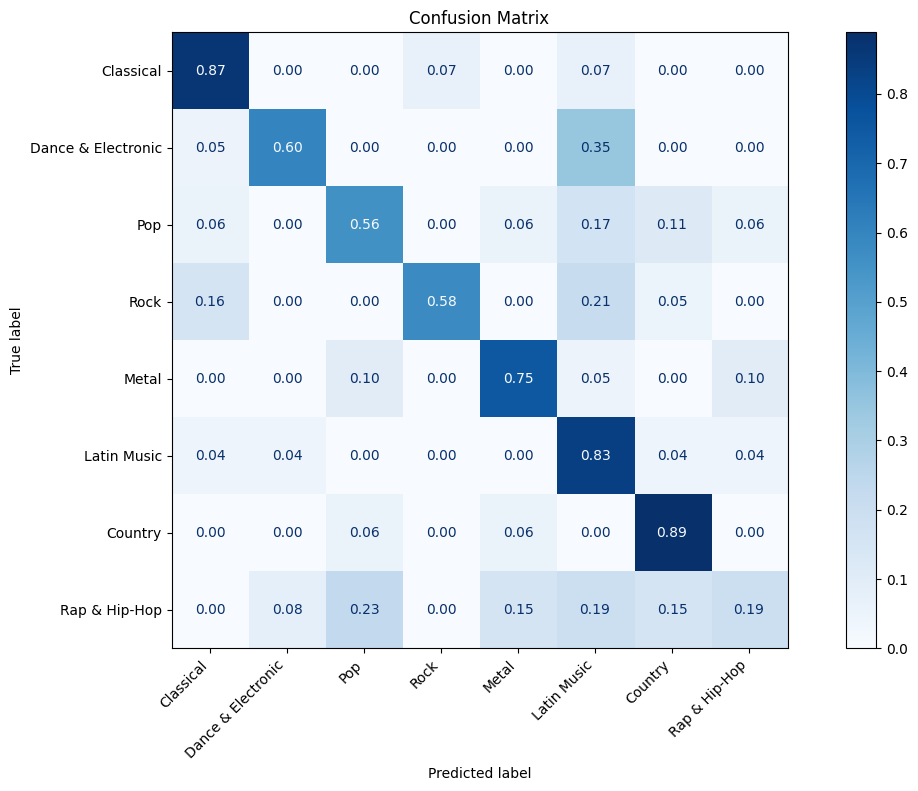

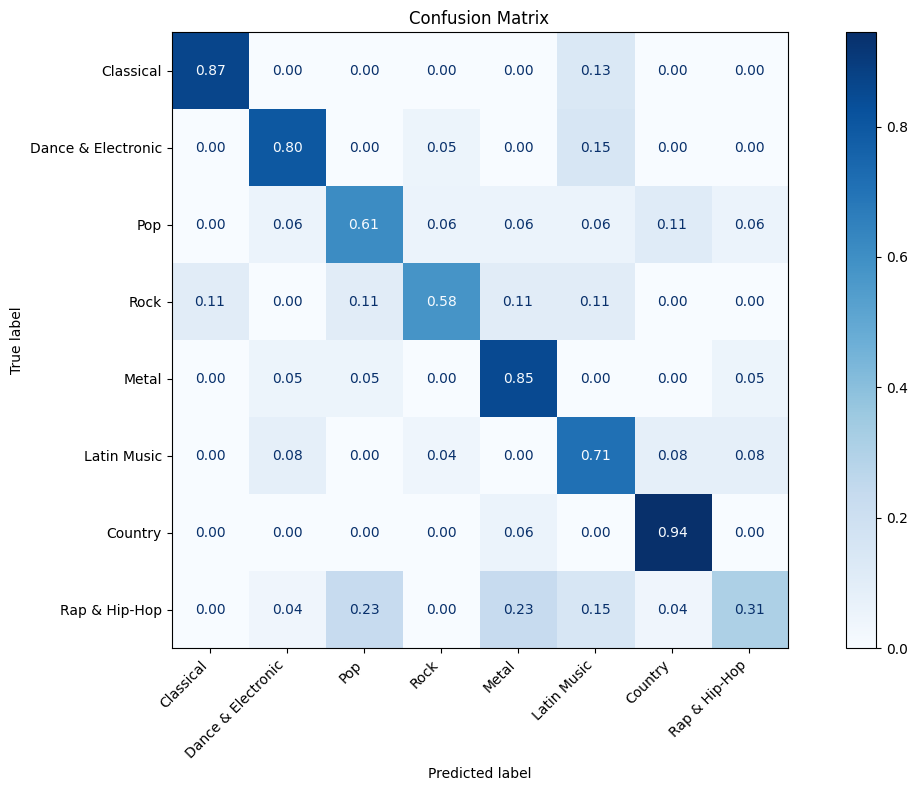

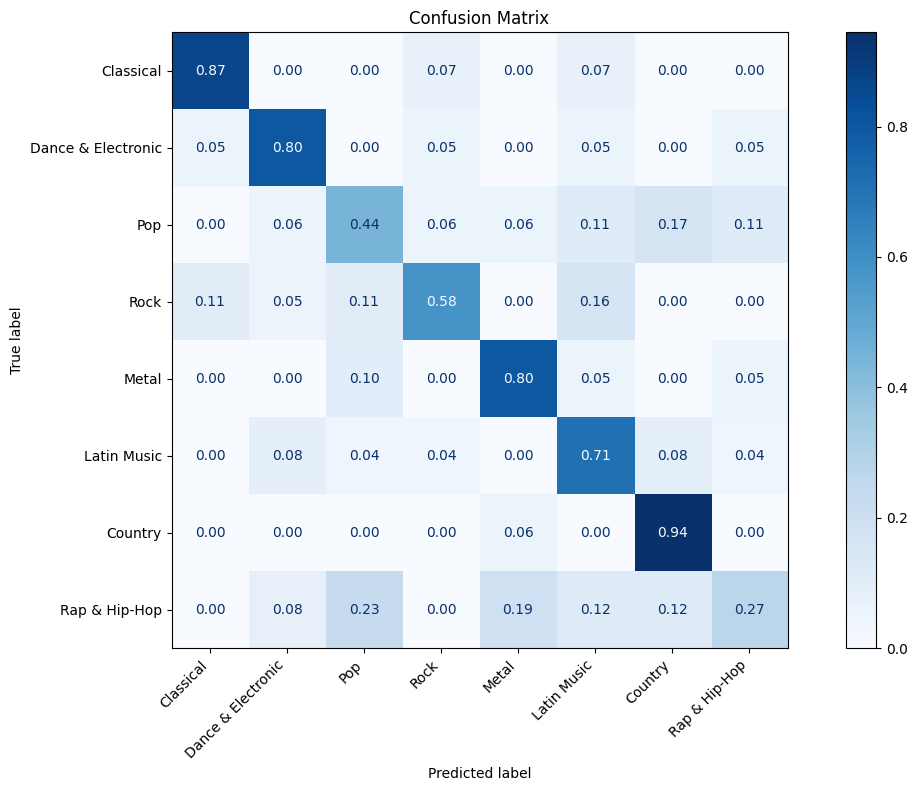

In [61]:
# Initialize classifiers
logistic_regression = LogisticRegression(max_iter=1000)
random_forest = RandomForestClassifier( max_depth = None, min_samples_leaf = 2, min_samples_split = 5, n_estimators = 200)
linear_svm = LinearSVC(loss='squared_hinge', tol=1e-3, C = 10, penalty = 'l2')

neural_network = MLPClassifier(
    activation='tanh',
    alpha=0.0019340450985343381,
    hidden_layer_sizes=(100, 100, 50, 50),
    learning_rate='adaptive',
    max_iter=300,
    solver='adam',
    random_state=42  # Add this for reproducibility
)

# Evaluate classifiers and combine results
results_combined_after_grid = []

# Evaluate classifiers for X_bow
results_combined_after_grid.append(['Logistic Regression', 'X_bow', f"{evaluate_model(logistic_regression, X_bow_train, y_train, X_bow_test, y_test):.2f}"])
results_combined_after_grid.append(['Random Forest', 'X_bow', f"{evaluate_model(random_forest, X_bow_train, y_train, X_bow_test, y_test):.2f}"])
results_combined_after_grid.append(['Linear SVM', 'X_bow', f"{evaluate_model(linear_svm, X_bow_train, y_train, X_bow_test, y_test):.2f}"])
results_combined_after_grid.append(['Neural Network', 'X_bow', f"{evaluate_model(neural_network, X_bow_train, y_train, X_bow_test, y_test):.2f}"])

# Evaluate classifiers for X_sem
results_combined_after_grid.append(['Logistic Regression', 'X_bow_sem', f"{evaluate_model(logistic_regression, X_bow_sem_train, y_train, X_bow_sem_test, y_test):.2f}"])
results_combined_after_grid.append(['Random Forest', 'X_bow_sem', f"{evaluate_model(random_forest, X_bow_sem_train, y_train, X_bow_sem_test, y_test):.2f}"])
results_combined_after_grid.append(['Linear SVM', 'X_bow_sem', f"{evaluate_model(linear_svm, X_bow_sem_train, y_train, X_bow_sem_test, y_test):.2f}"])
results_combined_after_grid.append(['Neural Network', 'X_bow_sem', f"{evaluate_model(neural_network, X_bow_sem_train, y_train, X_bow_sem_test, y_test):.2f}"])

# Evaluate classifiers for X_bow_sent
results_combined_after_grid.append(['Logistic Regression', 'X_bow_sent', f"{evaluate_model(logistic_regression, X_bow_sent_train, y_train, X_bow_sent_test, y_test):.2f}"])
results_combined_after_grid.append(['Random Forest', 'X_bow_sent', f"{evaluate_model(random_forest, X_bow_sent_train, y_train, X_bow_sent_test, y_test):.2f}"])
results_combined_after_grid.append(['Linear SVM', 'X_bow_sent', f"{evaluate_model(linear_svm, X_bow_sent_train, y_train, X_bow_sent_test, y_test):.2f}"])
results_combined_after_grid.append(['Neural Network', 'X_bow_sent', f"{evaluate_model(neural_network, X_bow_sent_train, y_train, X_bow_sent_test, y_test):.2f}"])

# Evaluate classifiers for X_bow_sem_sent
results_combined_after_grid.append(['Logistic Regression', 'X_bow_sem_sent', f"{evaluate_model(logistic_regression, X_bow_sem_sent_train, y_train, X_bow_sem_sent_test, y_test):.2f}"])
results_combined_after_grid.append(['Random Forest', 'X_bow_sem_sent', f"{evaluate_model(random_forest, X_bow_sem_sent_train, y_train, X_bow_sem_sent_test, y_test):.2f}"])
results_combined_after_grid.append(['Linear SVM', 'X_bow_sem_sent', f"{evaluate_model(linear_svm, X_bow_sem_sent_train, y_train, X_bow_sem_sent_test, y_test):.2f}"])
results_combined_after_grid.append(['Neural Network', 'X_bow_sem_sent', f"{evaluate_model(neural_network, X_bow_sem_sent_train, y_train, X_bow_sem_sent_test, y_test):.2f}"])


In [62]:
# Create a table using pandas
results_after_grid_df = pd.DataFrame(results_combined_after_grid, columns=['Classifier', 'Dataset', 'Accuracy'])
results_after_grid_pivot = results_after_grid_df.pivot(index='Classifier', columns='Dataset', values='Accuracy')

# Display the table
print(tabulate(results_after_grid_pivot, headers='keys', tablefmt='grid'))

+---------------------+---------+-------------+------------------+--------------+
| Classifier          |   X_bow |   X_bow_sem |   X_bow_sem_sent |   X_bow_sent |
+=====================+=========+=============+==================+==============+
| Linear SVM          |    0.69 |        0.71 |             0.72 |         0.68 |
+---------------------+---------+-------------+------------------+--------------+
| Logistic Regression |    0.63 |        0.67 |             0.69 |         0.64 |
+---------------------+---------+-------------+------------------+--------------+
| Neural Network      |    0.66 |        0.63 |             0.68 |         0.66 |
+---------------------+---------+-------------+------------------+--------------+
| Random Forest       |    0.62 |        0.69 |             0.66 |         0.64 |
+---------------------+---------+-------------+------------------+--------------+


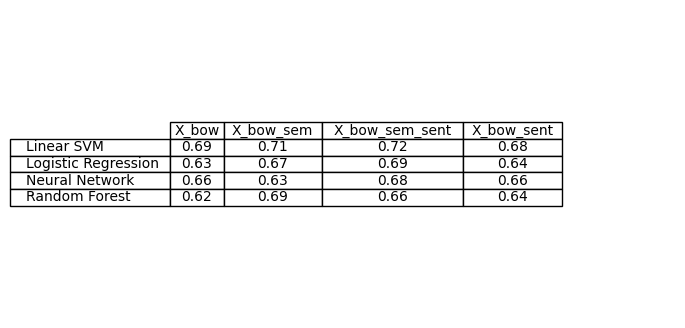

In [63]:
# Convert 'Accuracy' column to numeric for plotting
results_after_grid_df['Accuracy'] = pd.to_numeric(results_after_grid_df['Accuracy'])

# Plotting the table
fig, ax = plt.subplots(figsize=(8, 4))
ax.axis('tight')
ax.axis('off')
table = ax.table(cellText=results_after_grid_pivot.values,
                 colLabels=results_after_grid_pivot.columns,
                 rowLabels=results_after_grid_pivot.index,
                 cellLoc='center',
                 loc='center')
table.auto_set_font_size(False)
table.set_fontsize(10)
table.auto_set_column_width(col=list(range(len(results_after_grid_pivot.columns))))
plt.show()

# Plotting the bar plot
# Convert Accuracy values to numeric before plotting
results_after_grid_pivot = results_after_grid_pivot.astype(float) #This line converts the 'Accuracy' values to numeric (float) before plotting
results_after_grid_pivot.plot(kind='bar', figsize=(10, 6))
plt.ylabel('Accuracy')
plt.title('Classifier Accuracy by Dataset (After Grid Search)')
plt.legend(title='Dataset')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.tight_layout()
plt.show()

# Findings

### Key Insights:
1. Combining semantic and sentiment features significantly boosts classification accuracy.
2. Sentiment analysis captures genre-specific emotional tones effectively.
3. Genre overlaps highlight nuanced sentiment and semantic similarities.



# Some tests and misc code

In [64]:
# The clustering is driven solely by the sentiment analysis scores,
# allowing you to group albums based on their emotional tone and sentiment expression.

X = sentiment_df

# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply KMeans clustering
kmeans = KMeans(n_clusters=8, random_state=42)  # Adjust the number of clusters as needed
products_df['cluster'] = kmeans.fit_predict(X_scaled)


# Analyze the distribution of genres within each cluster
for cluster in range(kmeans.n_clusters):
    print(f"Cluster {cluster}:")
    print(products_df[products_df['cluster'] == cluster]['genre'].value_counts())
    print("\n")

Cluster 0:
genre
Metal                 6
Rock                  5
Classical             4
Rap & Hip-Hop         4
Country               3
Latin Music           3
Dance & Electronic    3
Pop                   2
Name: count, dtype: int64


Cluster 1:
genre
Pop                   30
Dance & Electronic    28
Metal                 22
Country               22
Rap & Hip-Hop         21
Classical             18
Latin Music           17
Rock                  15
Name: count, dtype: int64


Cluster 2:
genre
Metal                 19
Latin Music           17
Rock                  17
Classical             15
Rap & Hip-Hop         15
Country               14
Pop                   11
Dance & Electronic    10
Name: count, dtype: int64


Cluster 3:
genre
Latin Music           5
Rap & Hip-Hop         4
Rock                  2
Country               2
Classical             2
Dance & Electronic    1
Pop                   1
Name: count, dtype: int64


Cluster 4:
genre
Latin Music           14
Country           

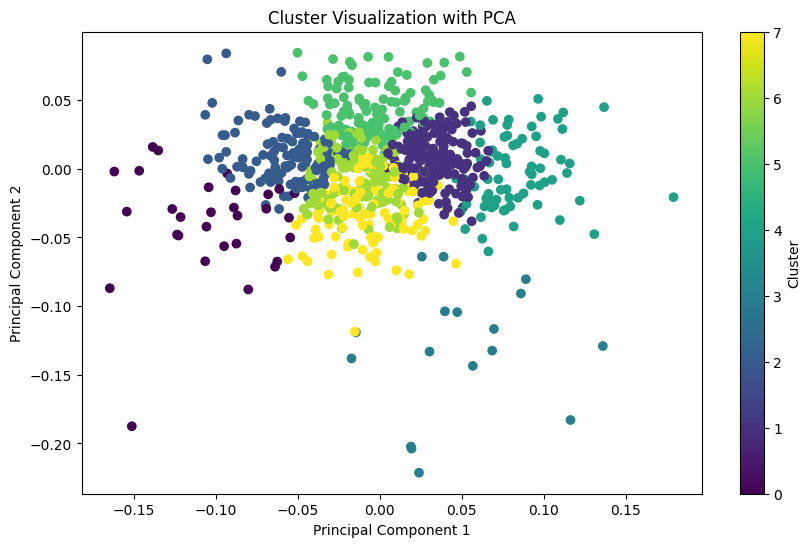

In [65]:
# Apply PCA for dimensionality reduction
pca = PCA(n_components=2)  # Reduce to 2 dimensions
X_pca = pca.fit_transform(X)

# Create a scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=products_df['cluster'], cmap='viridis')
plt.title('Cluster Visualization with PCA')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(label='Cluster')
plt.show()

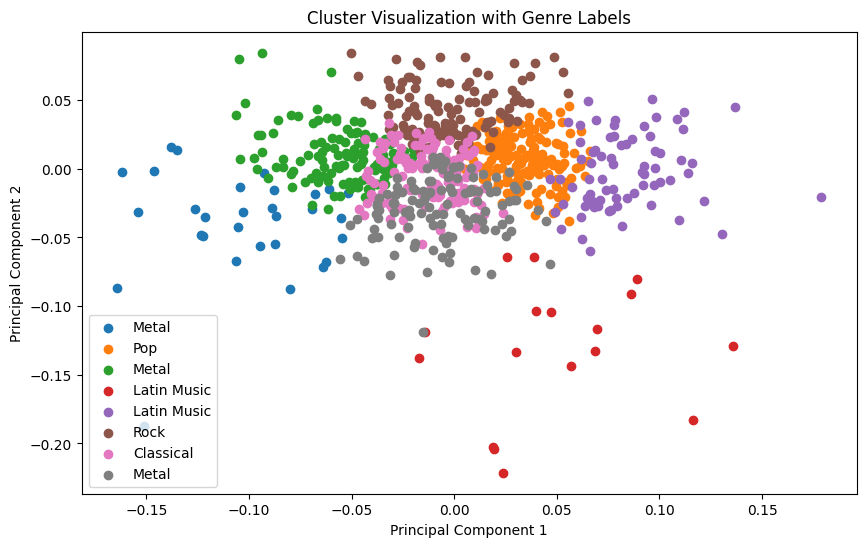

In [66]:
# Get the most frequent genre for each cluster
cluster_genres = products_df.groupby('cluster')['genre'].agg(lambda x: x.value_counts().index[0])

# Create a scatter plot with genre labels
plt.figure(figsize=(10, 6))
for cluster, genre in cluster_genres.items():
    plt.scatter(
        X_pca[products_df['cluster'] == cluster, 0],
        X_pca[products_df['cluster'] == cluster, 1],
        label=genre,
    )
plt.title('Cluster Visualization with Genre Labels')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.show()

<ipython-input-67-ed40caa20134>:7: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  heatmap_data = pd.pivot_table(


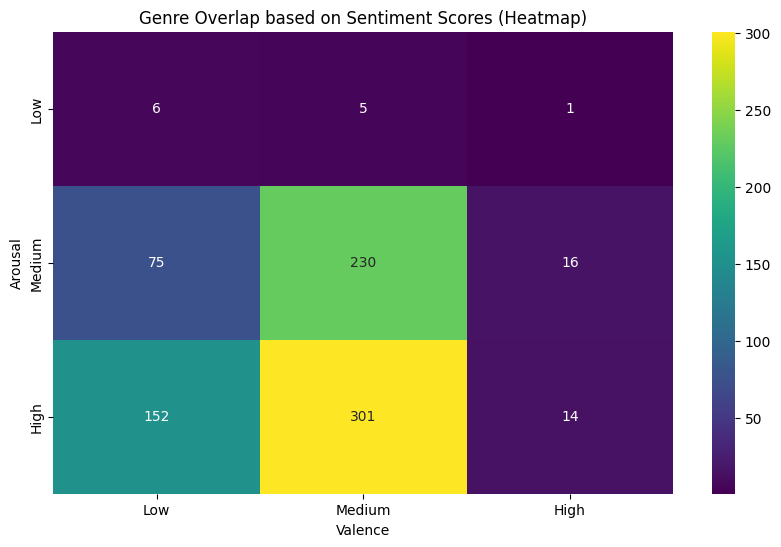

In [67]:
# Assuming you have a dataframe 'products_df' with genre and sentiment scores (e.g., valence, arousal)
# Create bins for sentiment scores
valence_bins = pd.cut(sentiment_df['eStrength'], bins=3, labels=['Low', 'Medium', 'High'])
arousal_bins = pd.cut(sentiment_df['eRatio'], bins=3, labels=['Low', 'Medium', 'High'])

# Create a pivot table to count genre occurrences in each sentiment bin combination
heatmap_data = pd.pivot_table(
    products_df,
    values='genre',
    index=arousal_bins,
    columns=valence_bins,
    aggfunc='count',
    fill_value=0,
)

# Plot the heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_data, annot=True, cmap='viridis', fmt='d')
plt.title('Genre Overlap based on Sentiment Scores (Heatmap)')
plt.xlabel('Valence')
plt.ylabel('Arousal')
plt.show()

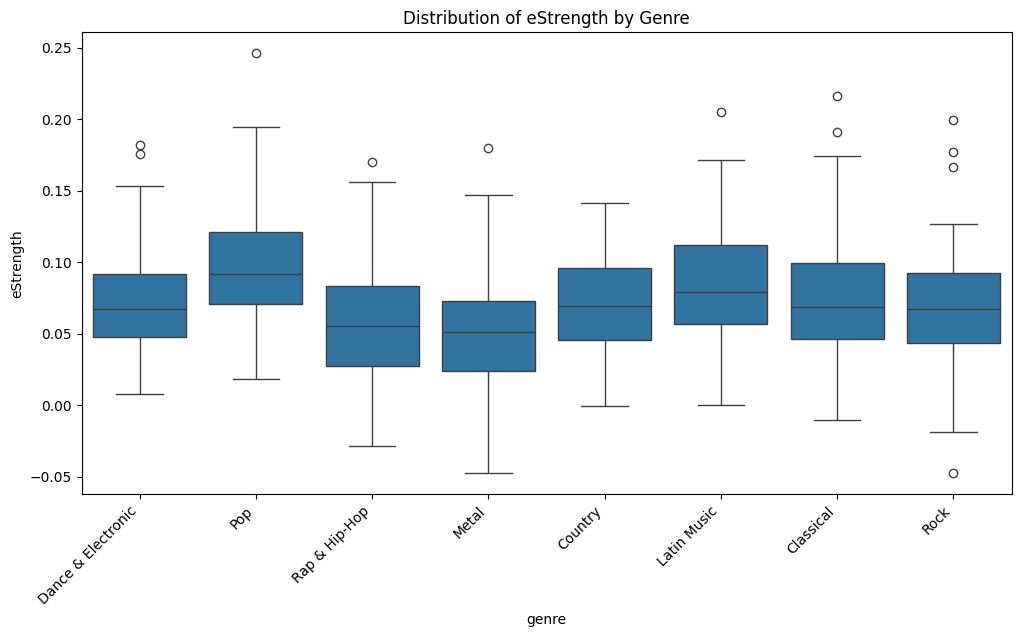

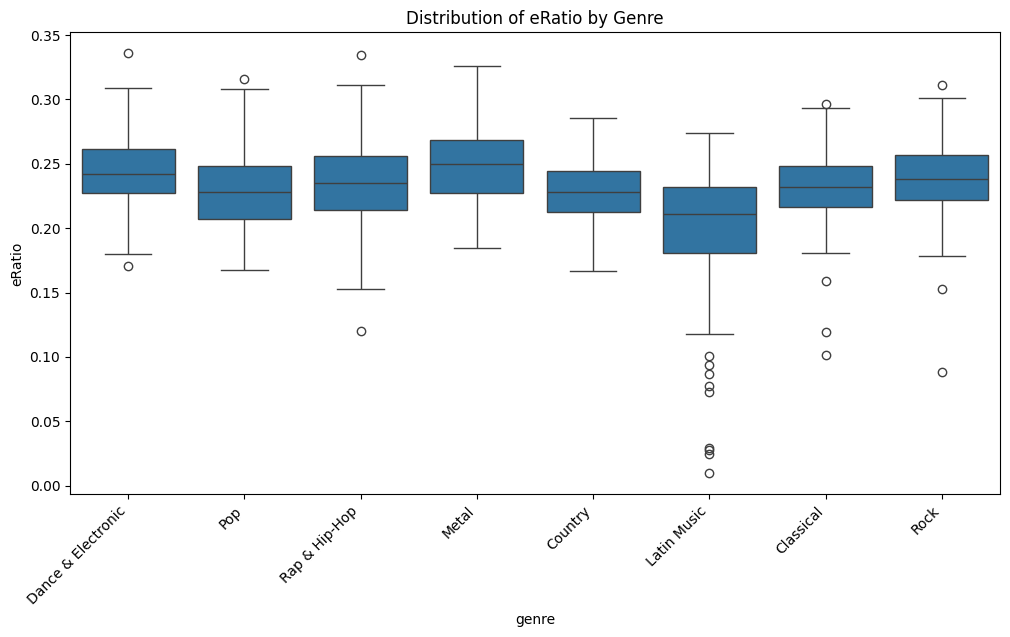

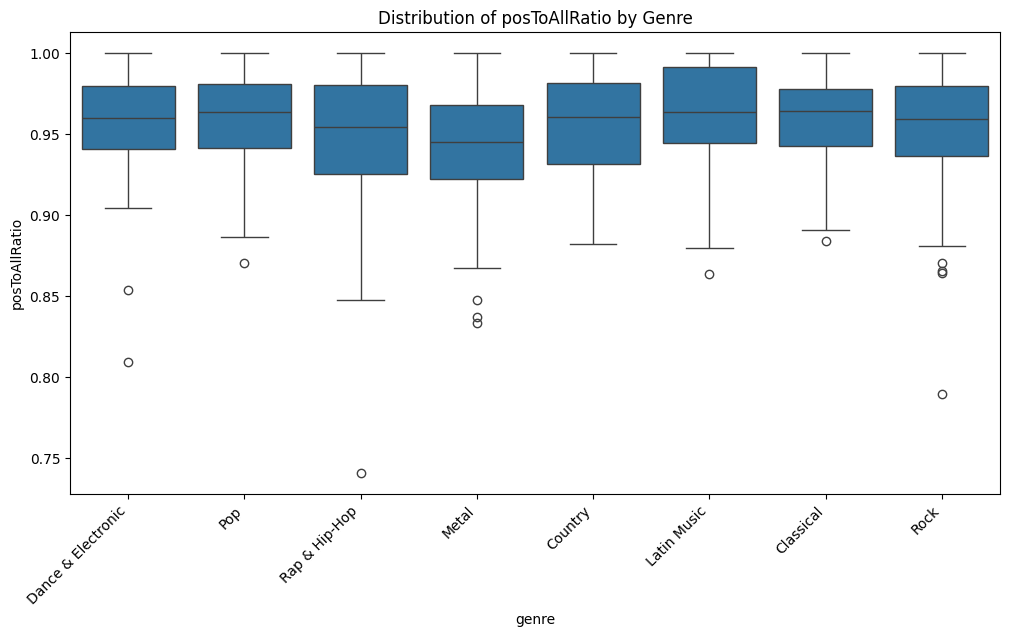

In [68]:
sentiment_genre_df = pd.concat([sentiment_df, products_df['genre']], axis=1)
sentiment_genre_df.head()

for feature in ['eStrength', 'eRatio', 'posToAllRatio']:
       plt.figure(figsize=(12, 6))
       sns.boxplot(x='genre', y=feature, data=sentiment_genre_df)
       plt.title(f'Distribution of {feature} by Genre')
       plt.xticks(rotation=45, ha='right')
       plt.show()

In [69]:
def extract_emotion_features(text):
    emotion_features = {'anger': 0, 'fear': 0, 'anticipation': 0, 'trust': 0,
                        'surprise': 0, 'sadness': 0, 'joy': 0, 'disgust': 0,
                        'positive': 0, 'negative': 0}  # Initialize feature dict

    # Analyze emotions using NRCLex
    emotions = NRCLex(text).raw_emotion_scores
    for emotion, score in emotions.items():
        if emotion in emotion_features:
            emotion_features[emotion] += score

    return emotion_features

# Apply the function to each row
products_df['emotion_features'] = products_df['all_text'].apply(extract_emotion_features)

# Expand dictionary columns into separate DataFrame columns
emotion_features_df = products_df['emotion_features'].apply(pd.Series)

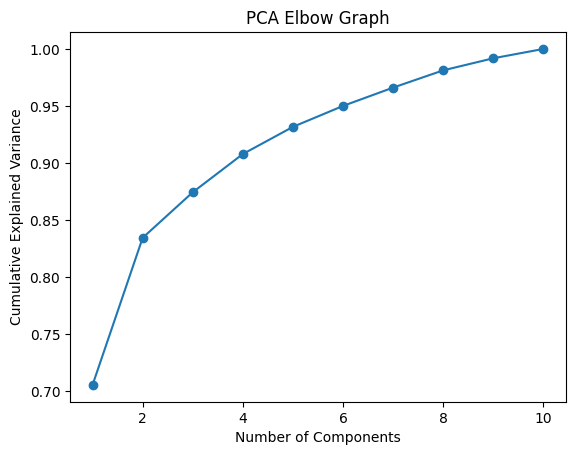

In [70]:
# Assuming emotion_features_df contains the emotion feature columns
scaler = StandardScaler()
scaled_emo_features = scaler.fit_transform(emotion_features_df)

# Fit PCA
pca = PCA()
pca.fit(scaled_emo_features)

# Plot explained variance
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), np.cumsum(pca.explained_variance_ratio_), marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA Elbow Graph')
plt.show()

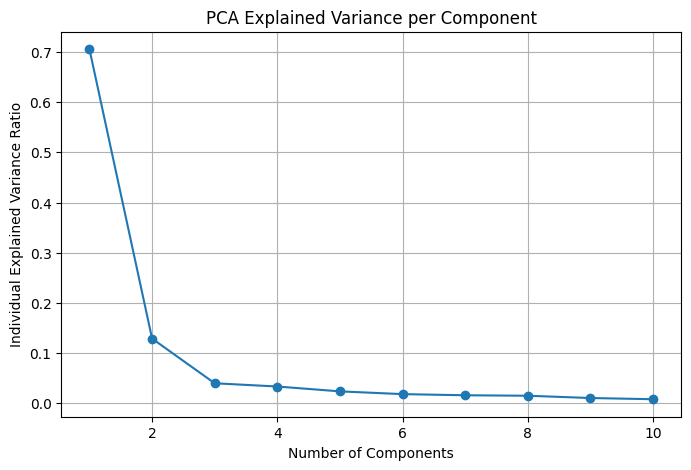

In [71]:
# Plot individual explained variance
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_, marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Individual Explained Variance Ratio')
plt.title('PCA Explained Variance per Component')
plt.grid()
plt.show()

Feature Contributions to Principal Components:
         anger      fear  anticipation     trust  surprise   sadness  \
PC1   0.324499  0.318520      0.324603  0.321866  0.309017  0.319153   
PC2   0.318535  0.339308     -0.247433 -0.267779 -0.203172  0.066386   
PC3  -0.079237 -0.055978     -0.346515 -0.283183 -0.274782  0.770885   
PC4  -0.039228 -0.022583     -0.038779 -0.488815  0.819293  0.094632   
PC5  -0.034529 -0.352442      0.052537 -0.150781  0.088413  0.104743   
PC6  -0.226561  0.164329      0.810380 -0.305226 -0.245374  0.208277   
PC7  -0.570848  0.713388     -0.218673 -0.002774  0.070387 -0.103395   
PC8   0.632172  0.344478      0.004010 -0.142369 -0.031652 -0.043524   
PC9  -0.079311  0.017420     -0.050690  0.606334  0.177039  0.429993   
PC10  0.033139 -0.025735     -0.044209  0.041822 -0.105638 -0.196687   

           joy   disgust  positive  negative  
PC1   0.304752  0.284344  0.332274  0.320624  
PC2  -0.438971  0.449130 -0.314207  0.334144  
PC3   0.267241 -0.1

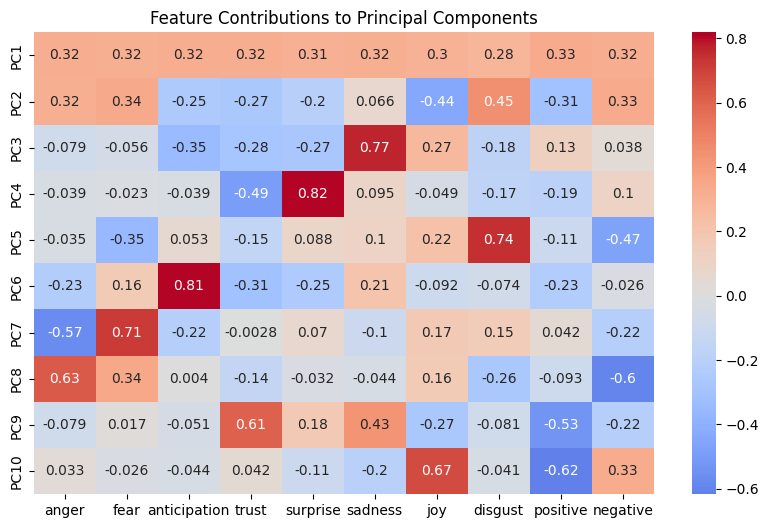

In [72]:
# Extract PCA loadings
features = emotion_features_df.columns
loadings = pd.DataFrame(pca.components_, columns=features)
loadings.index = [f"PC{i+1}" for i in range(len(pca.components_))]

# Display the loadings
print("Feature Contributions to Principal Components:")
print(loadings)

plt.figure(figsize=(10, 6))
sns.heatmap(loadings, annot=True, cmap="coolwarm", center=0)
plt.title("Feature Contributions to Principal Components")
plt.show()

In [73]:
optimal_components = 5
pca = PCA(n_components=optimal_components)
reduced_features = pca.fit_transform(scaled_emo_features)
print(scaled_emo_features)

[[ 0.63153816  0.26221129  0.59192233 ... -0.72134213  0.39733964
   0.68264945]
 [-0.08510089  0.26221129 -0.03115381 ...  0.31843031 -0.3877711
   0.47332804]
 [ 0.27321864  0.26221129 -0.23884585 ... -0.72134213 -0.09335457
   0.05468522]
 ...
 [-0.80173994 -0.75773539 -0.23884585 ... -0.20145591 -0.68218763
  -0.57327901]
 [-0.44342041 -0.07777093 -1.06961404 ... -0.20145591 -0.78032647
   0.68264945]
 [-0.44342041  0.60219352 -0.65422995 ...  0.83831653 -0.3877711
   0.05468522]]


In [74]:
# Split emotion_features_df into train and test sets before combining
emotion_features_train, emotion_features_test, _, _ = train_test_split(
    scaled_emo_features, y, test_size=0.2, random_state=42
)


In [75]:
# Combine features (BOW, Sentiment, Emotion)
X_combined_train_new = hstack((X_bow_train, emotion_features_train), format='csr')
X_combined_test_new = hstack((X_bow_test, emotion_features_test), format='csr')

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1243: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


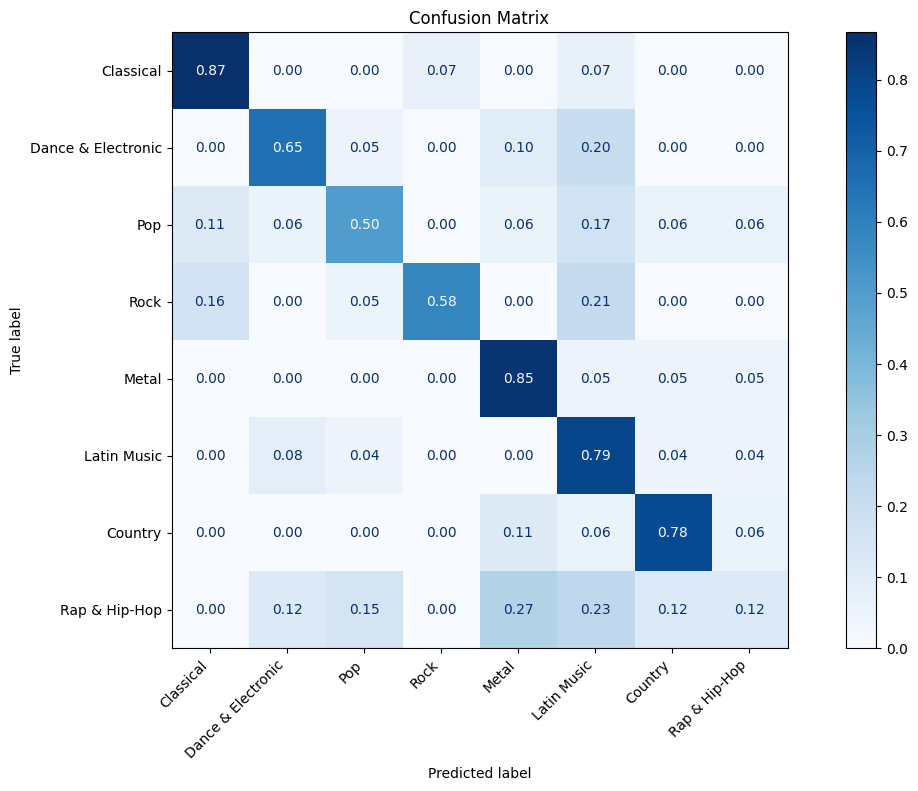

Accuracy: 0.62


In [76]:
# Initialize and train LinearSVC with increased max_iter and adjusted C
linear_svm = LinearSVC(loss='squared_hinge', tol=1e-3, C=1, penalty='l2', max_iter=5000)

accuracy = evaluate_model(linear_svm, X_combined_train_new, y_train, X_combined_test_new, y_test)
print(f"Accuracy: {accuracy:.2f}")

                                                     all_text  \
B003JOIRE0  After listening to the interview with the Krug...   
B000007V15  Dannii hits again with the 1997 release of Gir...   
B00004SDJF  First I must mention the excellent recording a...   
B00005J8S2  This is the 2002 UK release of Queen Latifah's...   
B00JJNLZG2  I've listend to this twice now.  Both times, I...   

                         genre  anger  fear  anticipation  trust  surprise  \
B003JOIRE0             Country      4     3             9      9         2   
B000007V15  Dance & Electronic      2     3             6      4         3   
B00004SDJF         Latin Music      3     3             5      6         3   
B00005J8S2       Rap & Hip-Hop      1     2             1      2         0   
B00JJNLZG2                 Pop      2     1             6      7         2   

            sadness  joy  disgust  positive  negative  
B003JOIRE0        2    6        0        19         8  
B000007V15        4    6    

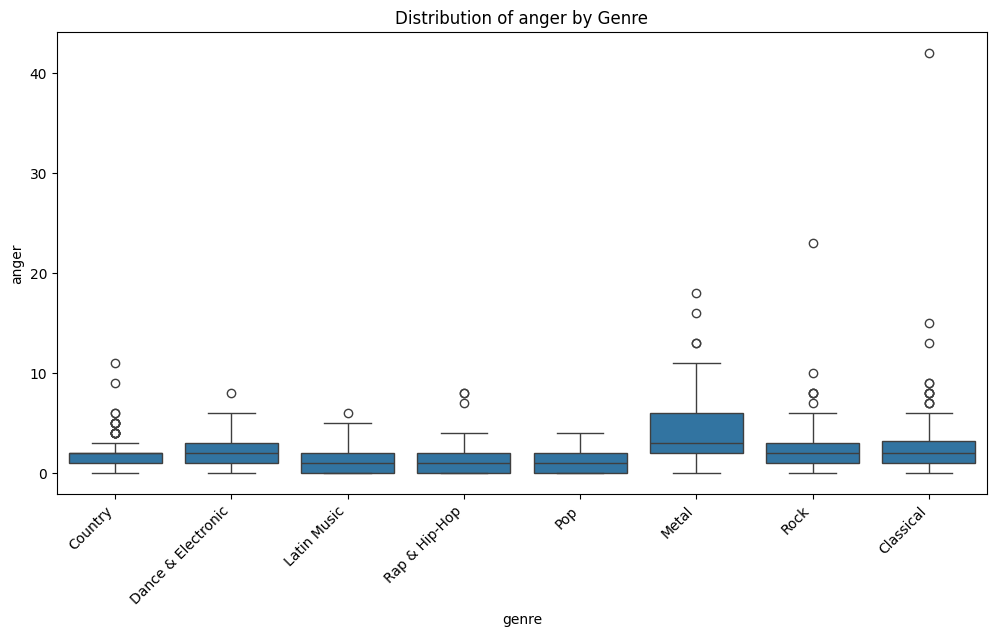

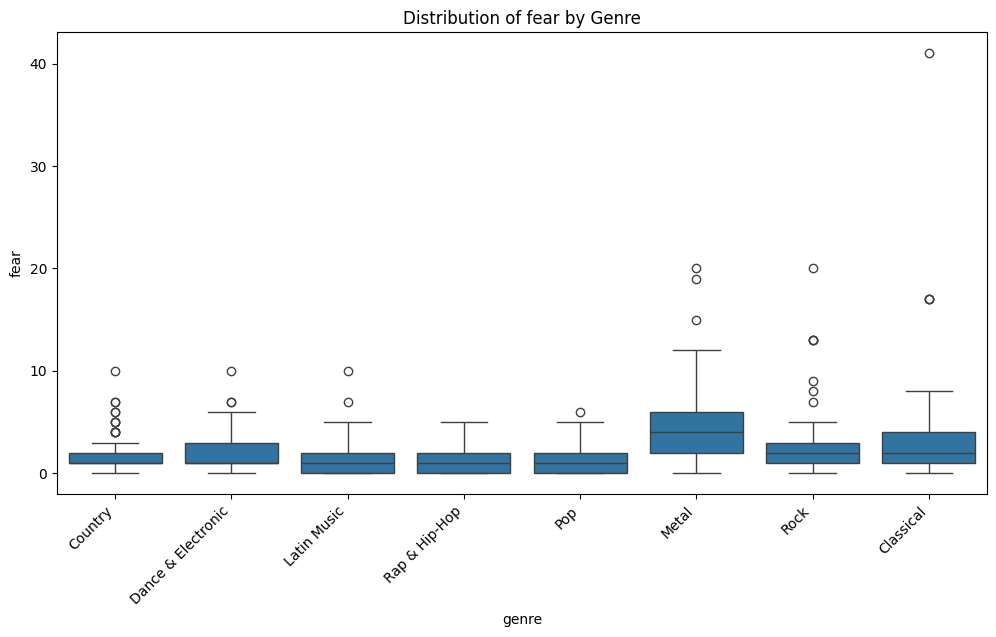

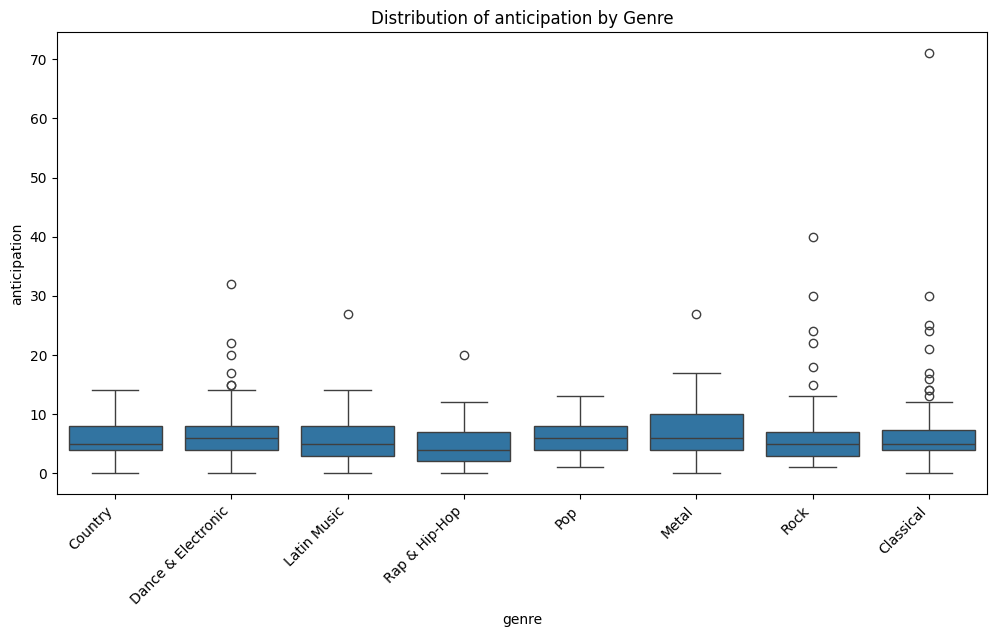

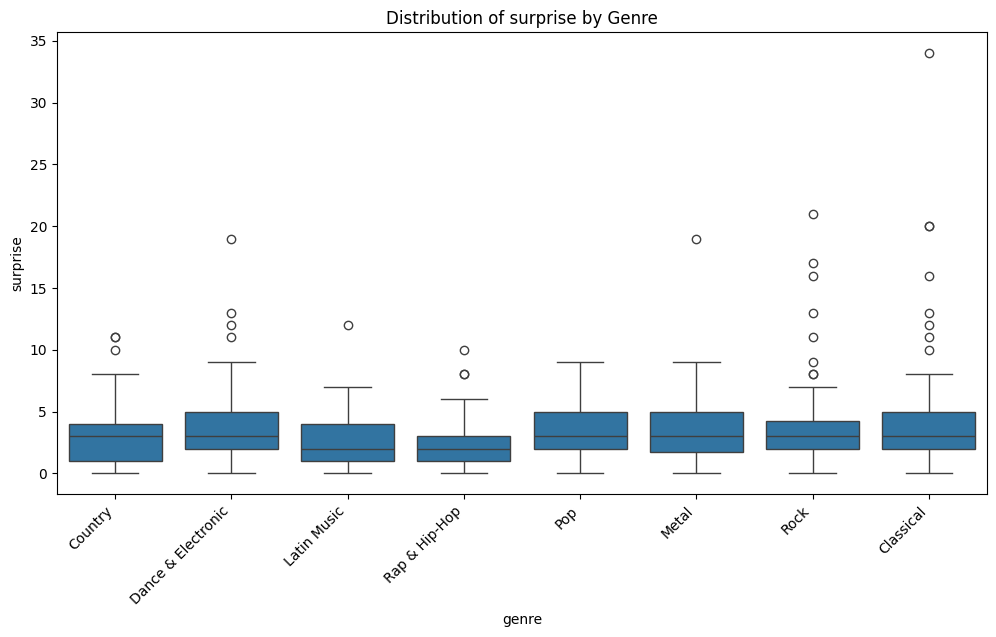

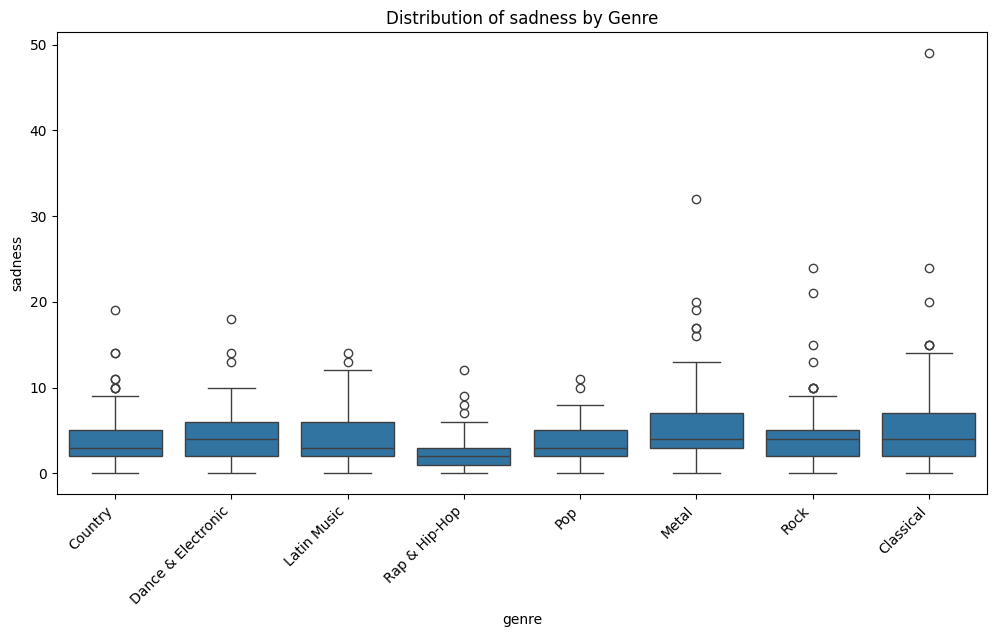

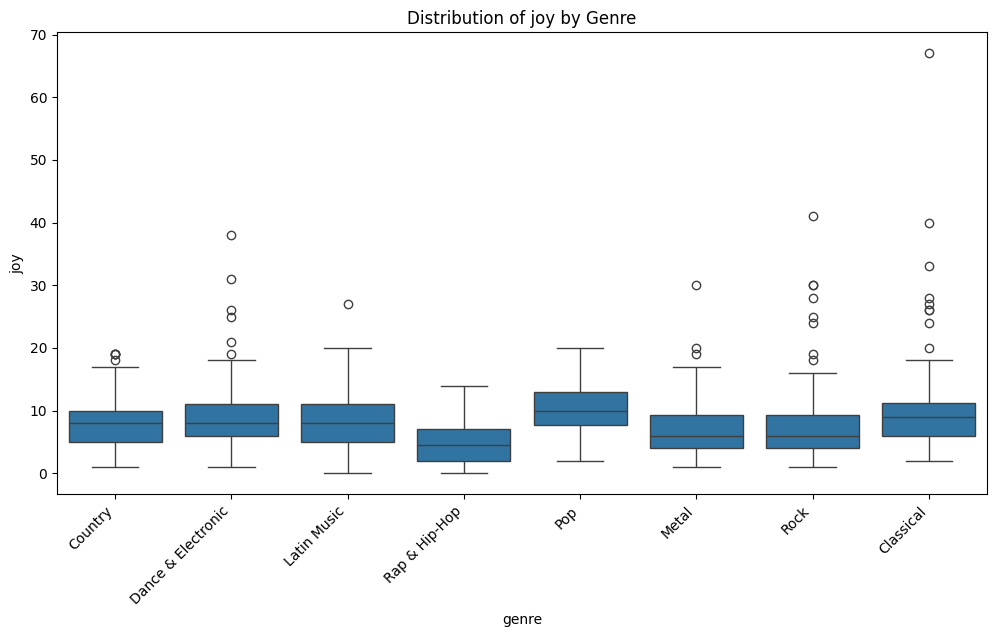

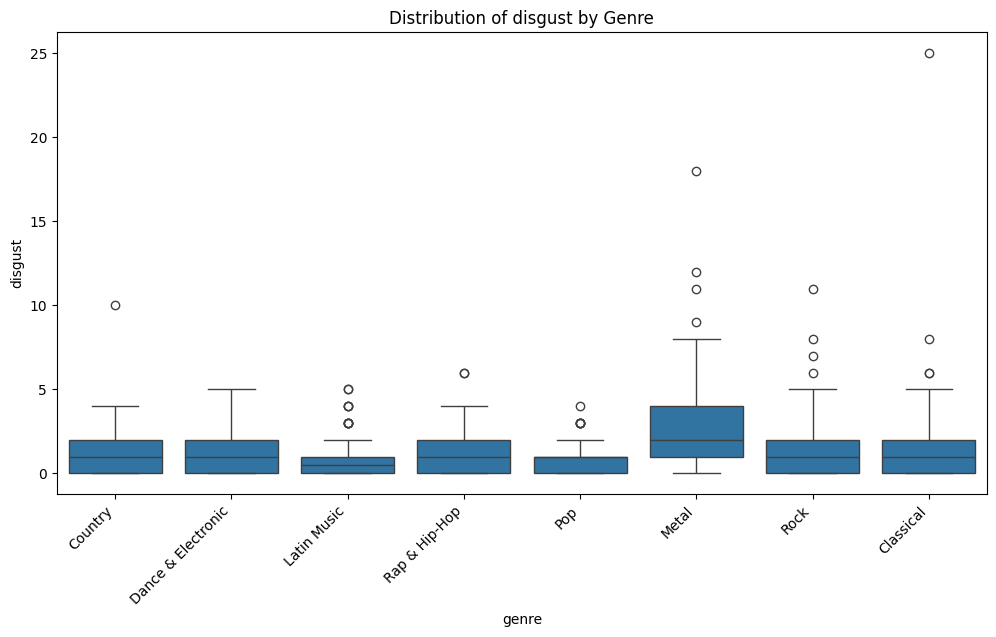

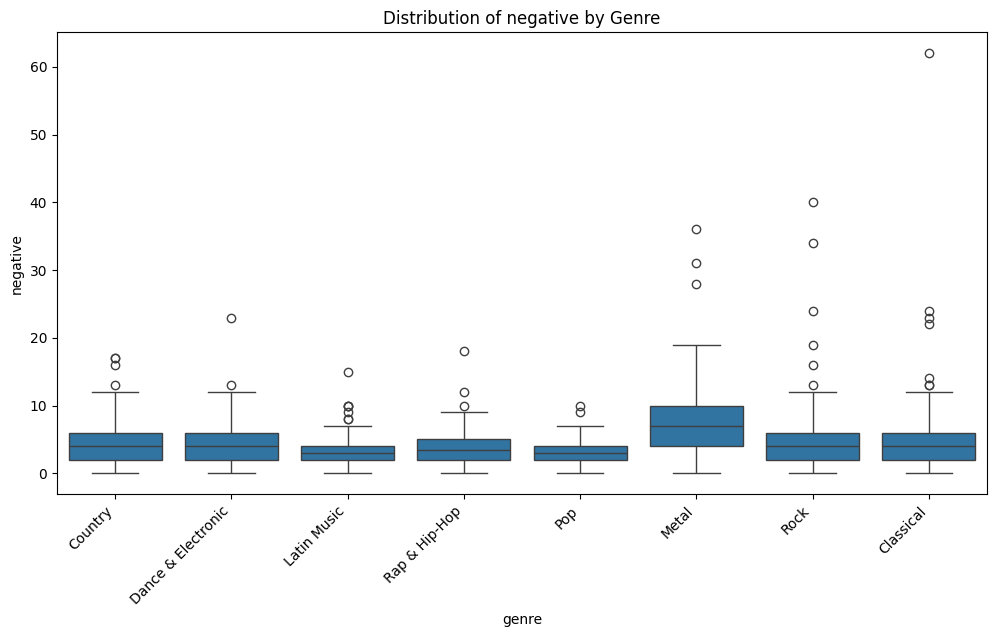

In [77]:
# Include 'genre' column when concatenating
sentiment_genre_df = pd.concat([products_df[['all_text', 'genre']], emotion_features_df], axis=1)  # Include 'genre' here
print(sentiment_genre_df.head())

for feature in ['anger', 'fear', 'anticipation', 'trust', 'surprise', 'sadness', 'joy', 'disgust', 'positive', 'negative']:
    plt.figure(figsize=(12, 6))
    sns.boxplot(x='genre', y=feature, data=sentiment_genre_df)
    plt.title(f'Distribution of {feature} by Genre')
    plt.xticks(rotation=45, ha='right')
    plt.show()

In [78]:
# Apply feature selection
selector = SelectKBest(score_func=f_classif, k=1000)  # Select top 1000 features
X_selected_train = selector.fit_transform(X_combined_train_new, y_train)
X_selected_test = selector.transform(hstack((X_bow_test, emotion_features_test), format='csr'))

# Initialize and train LinearSVC with increased max_iter and adjusted C
linear_svm = LinearSVC(loss='squared_hinge', tol=1e-3, C=1, penalty='l2', max_iter=5000)

accuracy = evaluate_model(linear_svm, X_selected_train, y_train, X_selected_test, y_test)
print(f"Accuracy: {accuracy:.2f}")

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1243: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Accuracy: 0.61


# MISC

In [79]:
# Save products dictionary
with open('/content/album_reviews.json', 'w') as f:
  json.dump(products, f, indent=4)

# Save semantics_df
semantics_dict = semantics_df.to_dict(orient='index')
with open('/content/album_semantics.json', 'w') as f:
  json.dump(semantics_dict, f, indent=4)

print("Files saved successfully!")

Files saved successfully!
